In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os

import arviz as az
import matplotlib.pyplot as plt
import neuromodels as nm
import numpy as np
import pandas as pd
import pylfi
import scipy.stats as stats
import seaborn as sns
from sklearn.metrics import mean_squared_error

[INFO] [2021.10.15 9:27:46 /Users/runner/miniforge3/conda-bld/nest-simulator_1633677025151/work/nestkernel/rng_manager.cpp:217 @ Network::create_rngs_] : Creating default RNGs
[INFO] [2021.10.15 9:27:46 /Users/runner/miniforge3/conda-bld/nest-simulator_1633677025151/work/nestkernel/rng_manager.cpp:260 @ Network::create_grng_] : Creating new default global RNG

              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: nest-2.20.2
 Built: Oct  8 2021 07:17:41

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
# Set plot style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

# Set fontsizes in figures
size = 10
tex_fonts = {
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern"],
    "axes.labelsize": size,
    "font.size": size,
    "legend.fontsize": size,
    "xtick.labelsize": size-1,
    "ytick.labelsize": size-1,
    'legend.handlelength': 2
}

plt.rcParams.update(tex_fonts)
plt.rc('text', usetex=True)

# Set path to save the figures
FIGURE_PATH = "./../latex/figures" 

def fig_path(fig_id):
    """
    Input name of figure to load or save with extension as dtype str
    """
    return os.path.join(FIGURE_PATH + "/", fig_id)

# Set figure size
pt = 410 #360

def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

fs = set_size(pt, fraction=1)
print(fs)

(5.673170056731701, 3.5062119190183605)


### Epsilon estimation vs number of simulations 

**Estimated $\epsilon$ from prior predictive distribution** 

Estimates the mean from 10 $\epsilon$ estimations per `n_sim` value. Also estimates the standard error of the mean (SEM).

Used 0.5-quantile (median)

The quantile-based rejection algorithm estimates $\epsilon$ by running `n_sims` simulations and calculating $\epsilon$ as the provided $p$-quantile of the distances. The following figure shows the effect of the number of simulation, effectively the number of samples from the prior predictive distribution, has on the estimation of $\epsilon$. This will inform us on how many simulations we should run in the pilot study (and the effect of the prior on the estimation). 

In [3]:
def plot_mean_sd(df, x_key, xlabel, ylabel, fs, filename=None, color='C0', facecolor='lightblue'):
    fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)
    mean = df.groupby(x_key).mean().to_numpy().ravel()
    sd = df.groupby(x_key).sem().to_numpy().ravel()
    x = df[x_key].unique()
    
    ax.plot(x, mean, '-o', label='Mean', color=color)
    ax.fill_between(x, mean - sd, mean + sd,
                    alpha=0.5,
                    facecolor=facecolor,
                    label='SEM'
                    )
    ax.set(xlabel=xlabel,
           ylabel=ylabel)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles,
              labels,
              loc='center left',
              bbox_to_anchor=(1.04, 0.5),
              fancybox=True,
              borderaxespad=0.1,
              ncol=1
             )
    if filename is not None:
        fig.savefig(fig_path(filename), format='pdf', dpi=300, bbox_inches='tight')

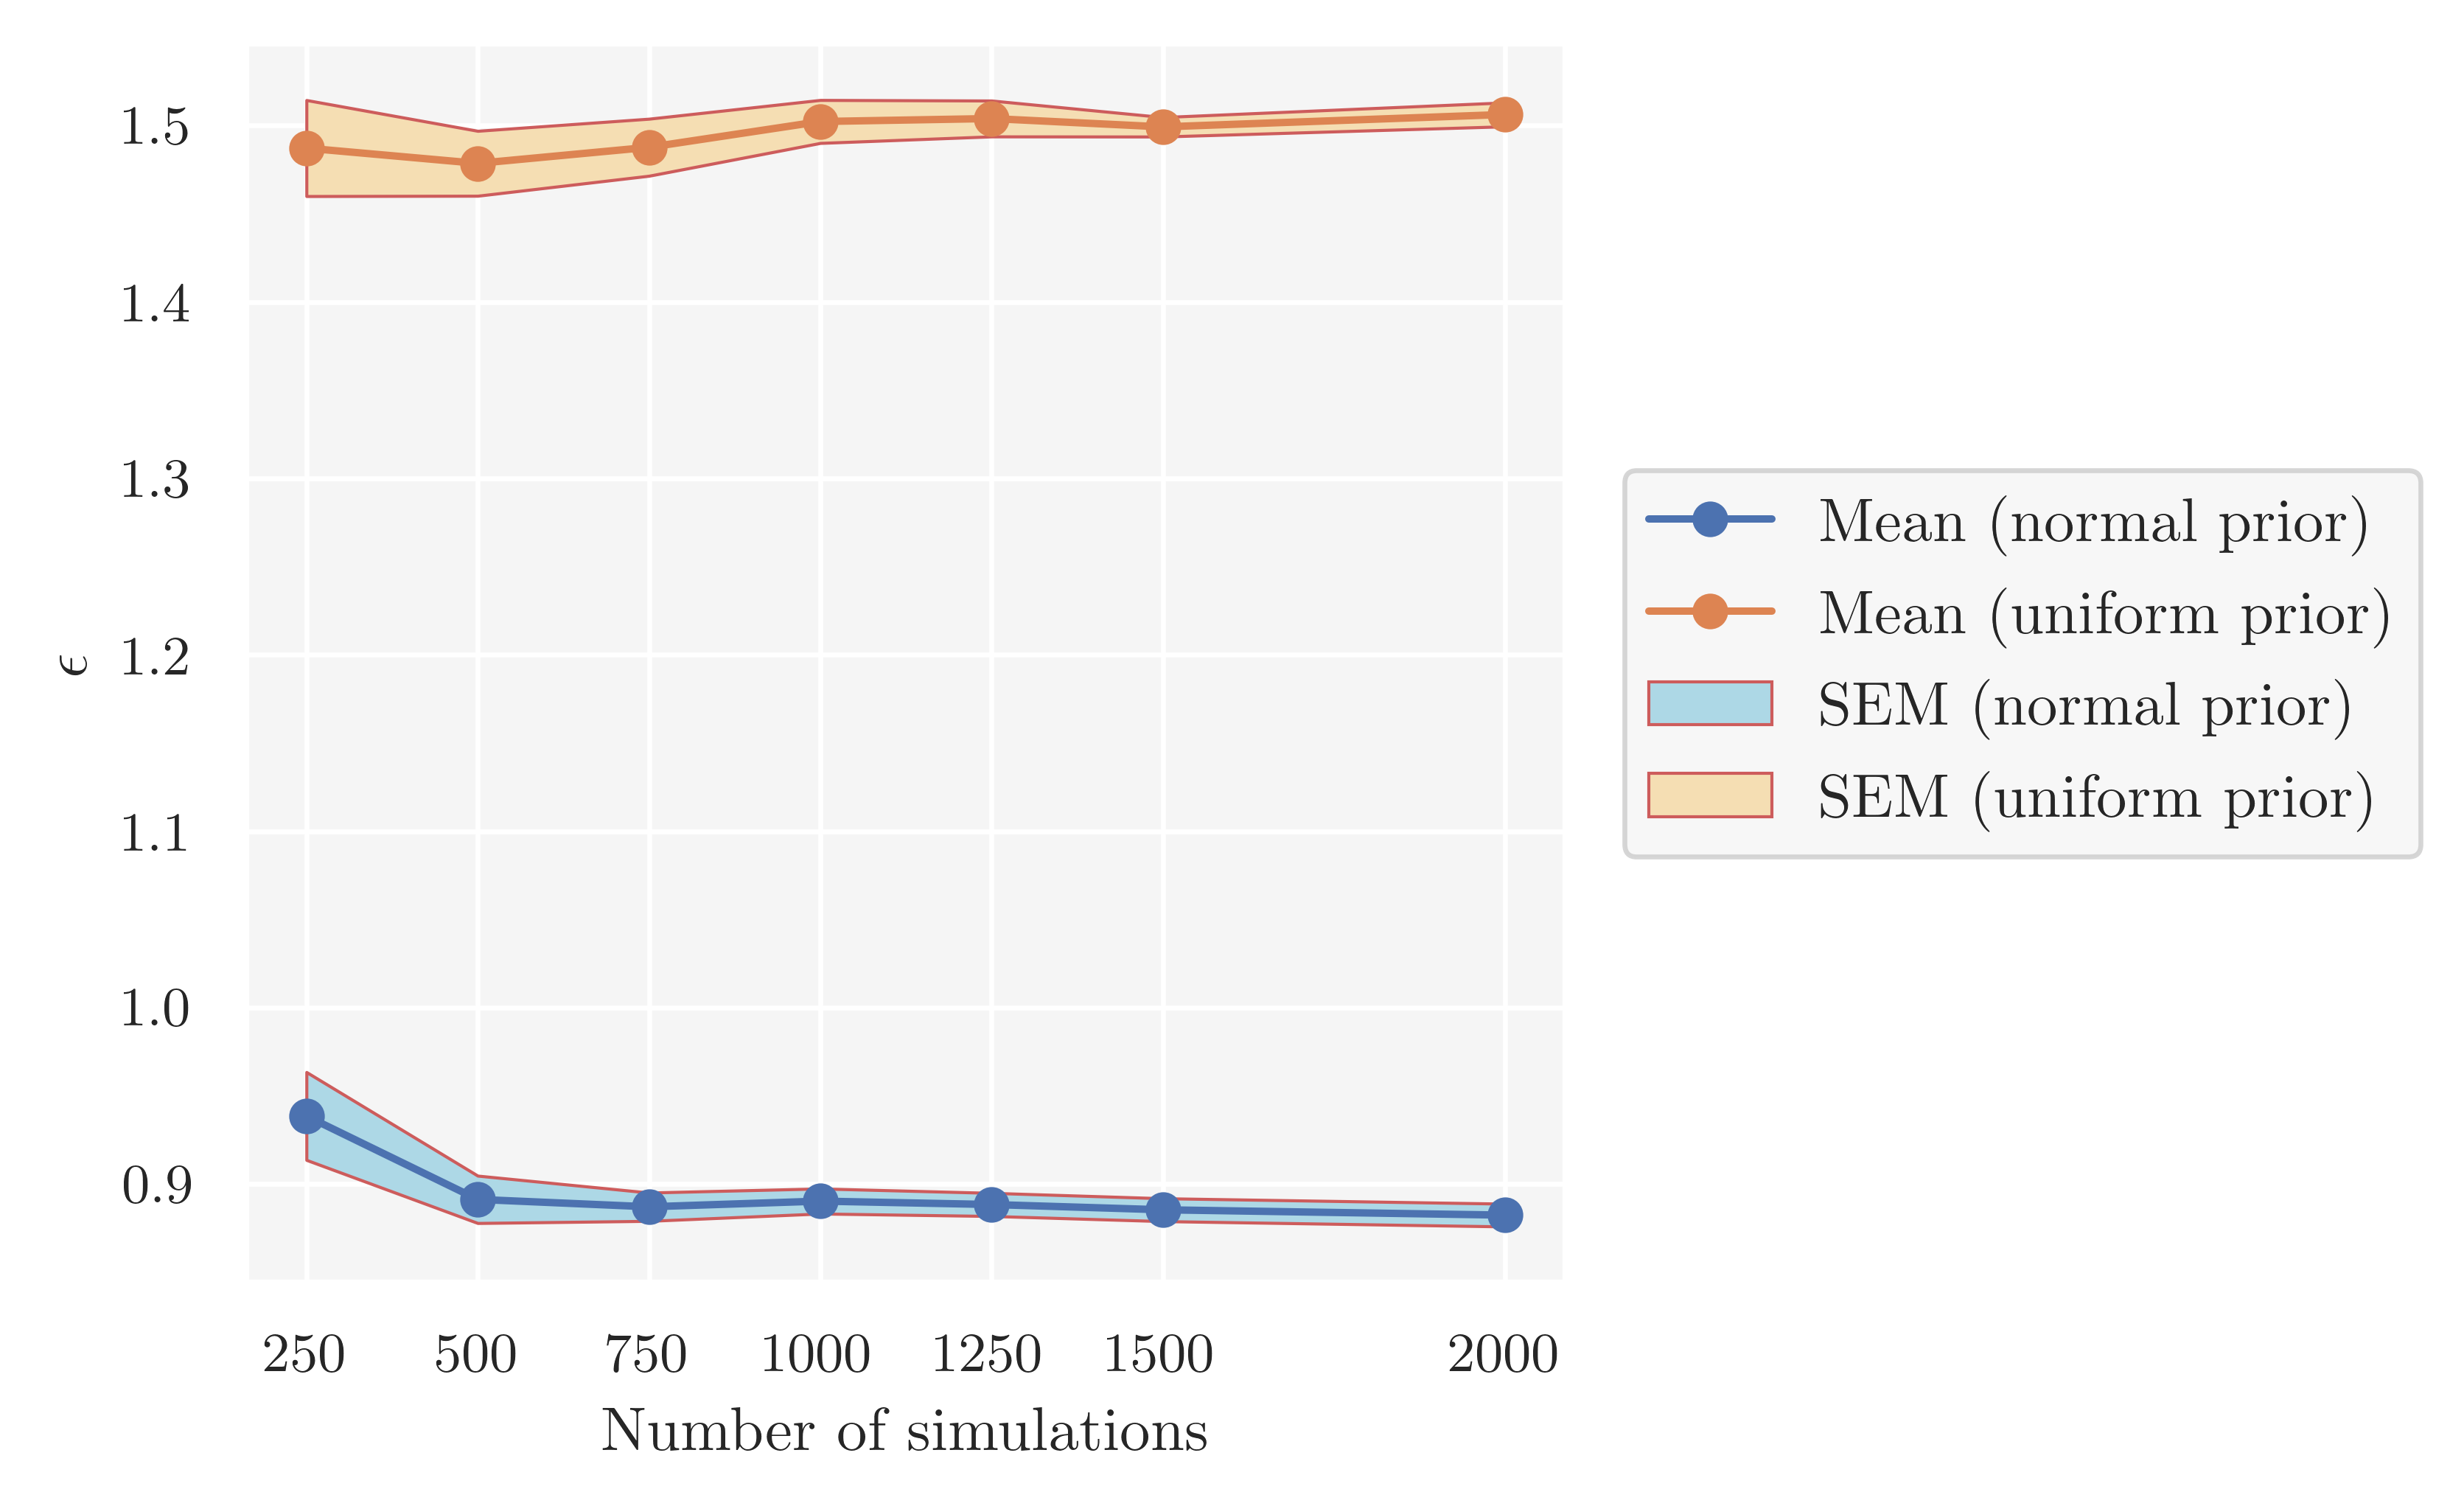

In [79]:
fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)

# normal prior
df_norm = pd.read_csv('data/pilot_eps_nsim_normal.csv')
x_norm = df_norm['n_sims'].unique()
mean_norm = df_norm.groupby('n_sims').mean().to_numpy().ravel()
sd_norm = df_norm.groupby('n_sims').sem().to_numpy().ravel() 

ax.plot(x_norm, 
        mean_norm,
        '-o', 
        label='Mean (normal prior)',
        #label=r'Mean ($\pi(\theta) = \mathcal{N}(\mu, \sigma^2)$)', 
        color='C0'
       )
ax.fill_between(x_norm, 
                mean_norm - sd_norm, 
                mean_norm + sd_norm,
                alpha=1.0,
                edgecolor='indianred',
                facecolor='lightblue',
                lw=0.5,
                label='SEM (normal prior)'
                #label=r'SEM ($\pi(\theta) = \mathcal{N}(\mu, \sigma^2)$)'
                )


# uniform prior
df_unif = pd.read_csv('data/pilot_eps_nsim_uniform.csv')
x_unif = df_unif['n_sims'].unique()
mean_unif = df_unif.groupby('n_sims').mean().to_numpy().ravel()
sd_unif = df_unif.groupby('n_sims').sem().to_numpy().ravel()

ax.plot(x_unif, 
        mean_unif,
        '-o', 
        label='Mean (uniform prior)',
        #label=r'Mean ($\pi(\theta) = \mathcal{U}(a, b)$)', 
        color='C1'
       )
ax.fill_between(x_unif, 
                mean_unif - sd_unif, 
                mean_unif + sd_unif,
                alpha=1.0,
                edgecolor='indianred',
                facecolor='wheat',
                lw=0.5,
                label='SEM (uniform prior)'
                #label=r'SEM ($\pi(\theta) = \mathcal{U}(a, b)$)'
                )

ax.set(xticks=x_norm,
       xlabel='Number of simulations',
       ylabel=r'$\epsilon$')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles,
          labels,
          loc='center left',
          bbox_to_anchor=(1.04, 0.5),
          fancybox=True,
          borderaxespad=0.1,
          ncol=1
         )
    
fig.savefig(fig_path('pilot_eps_nsims.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

With an informative prior, tradeoff between estimation accuracy and computation speed: figure indicates that 1000-1500 simulations are sufficient

With uninformative prior: 1500 - 2000. Not surprising; we sample from the prior predictive distribution and a prior with less certainty is bound to give more spread in its estimate.

Higher $\epsilon$ with uniform prior than with normal centered at ground truth values expected: the distances generated from uniform will have more variability and the parameter samples are less likely to be in the direct vicinity of the ground truth values => observed and simulated summary statistics will generally be further apart.

The colored circle markers indicate the estimated mean and the black vertical lines the estimated standard error of the mean (SEM). 

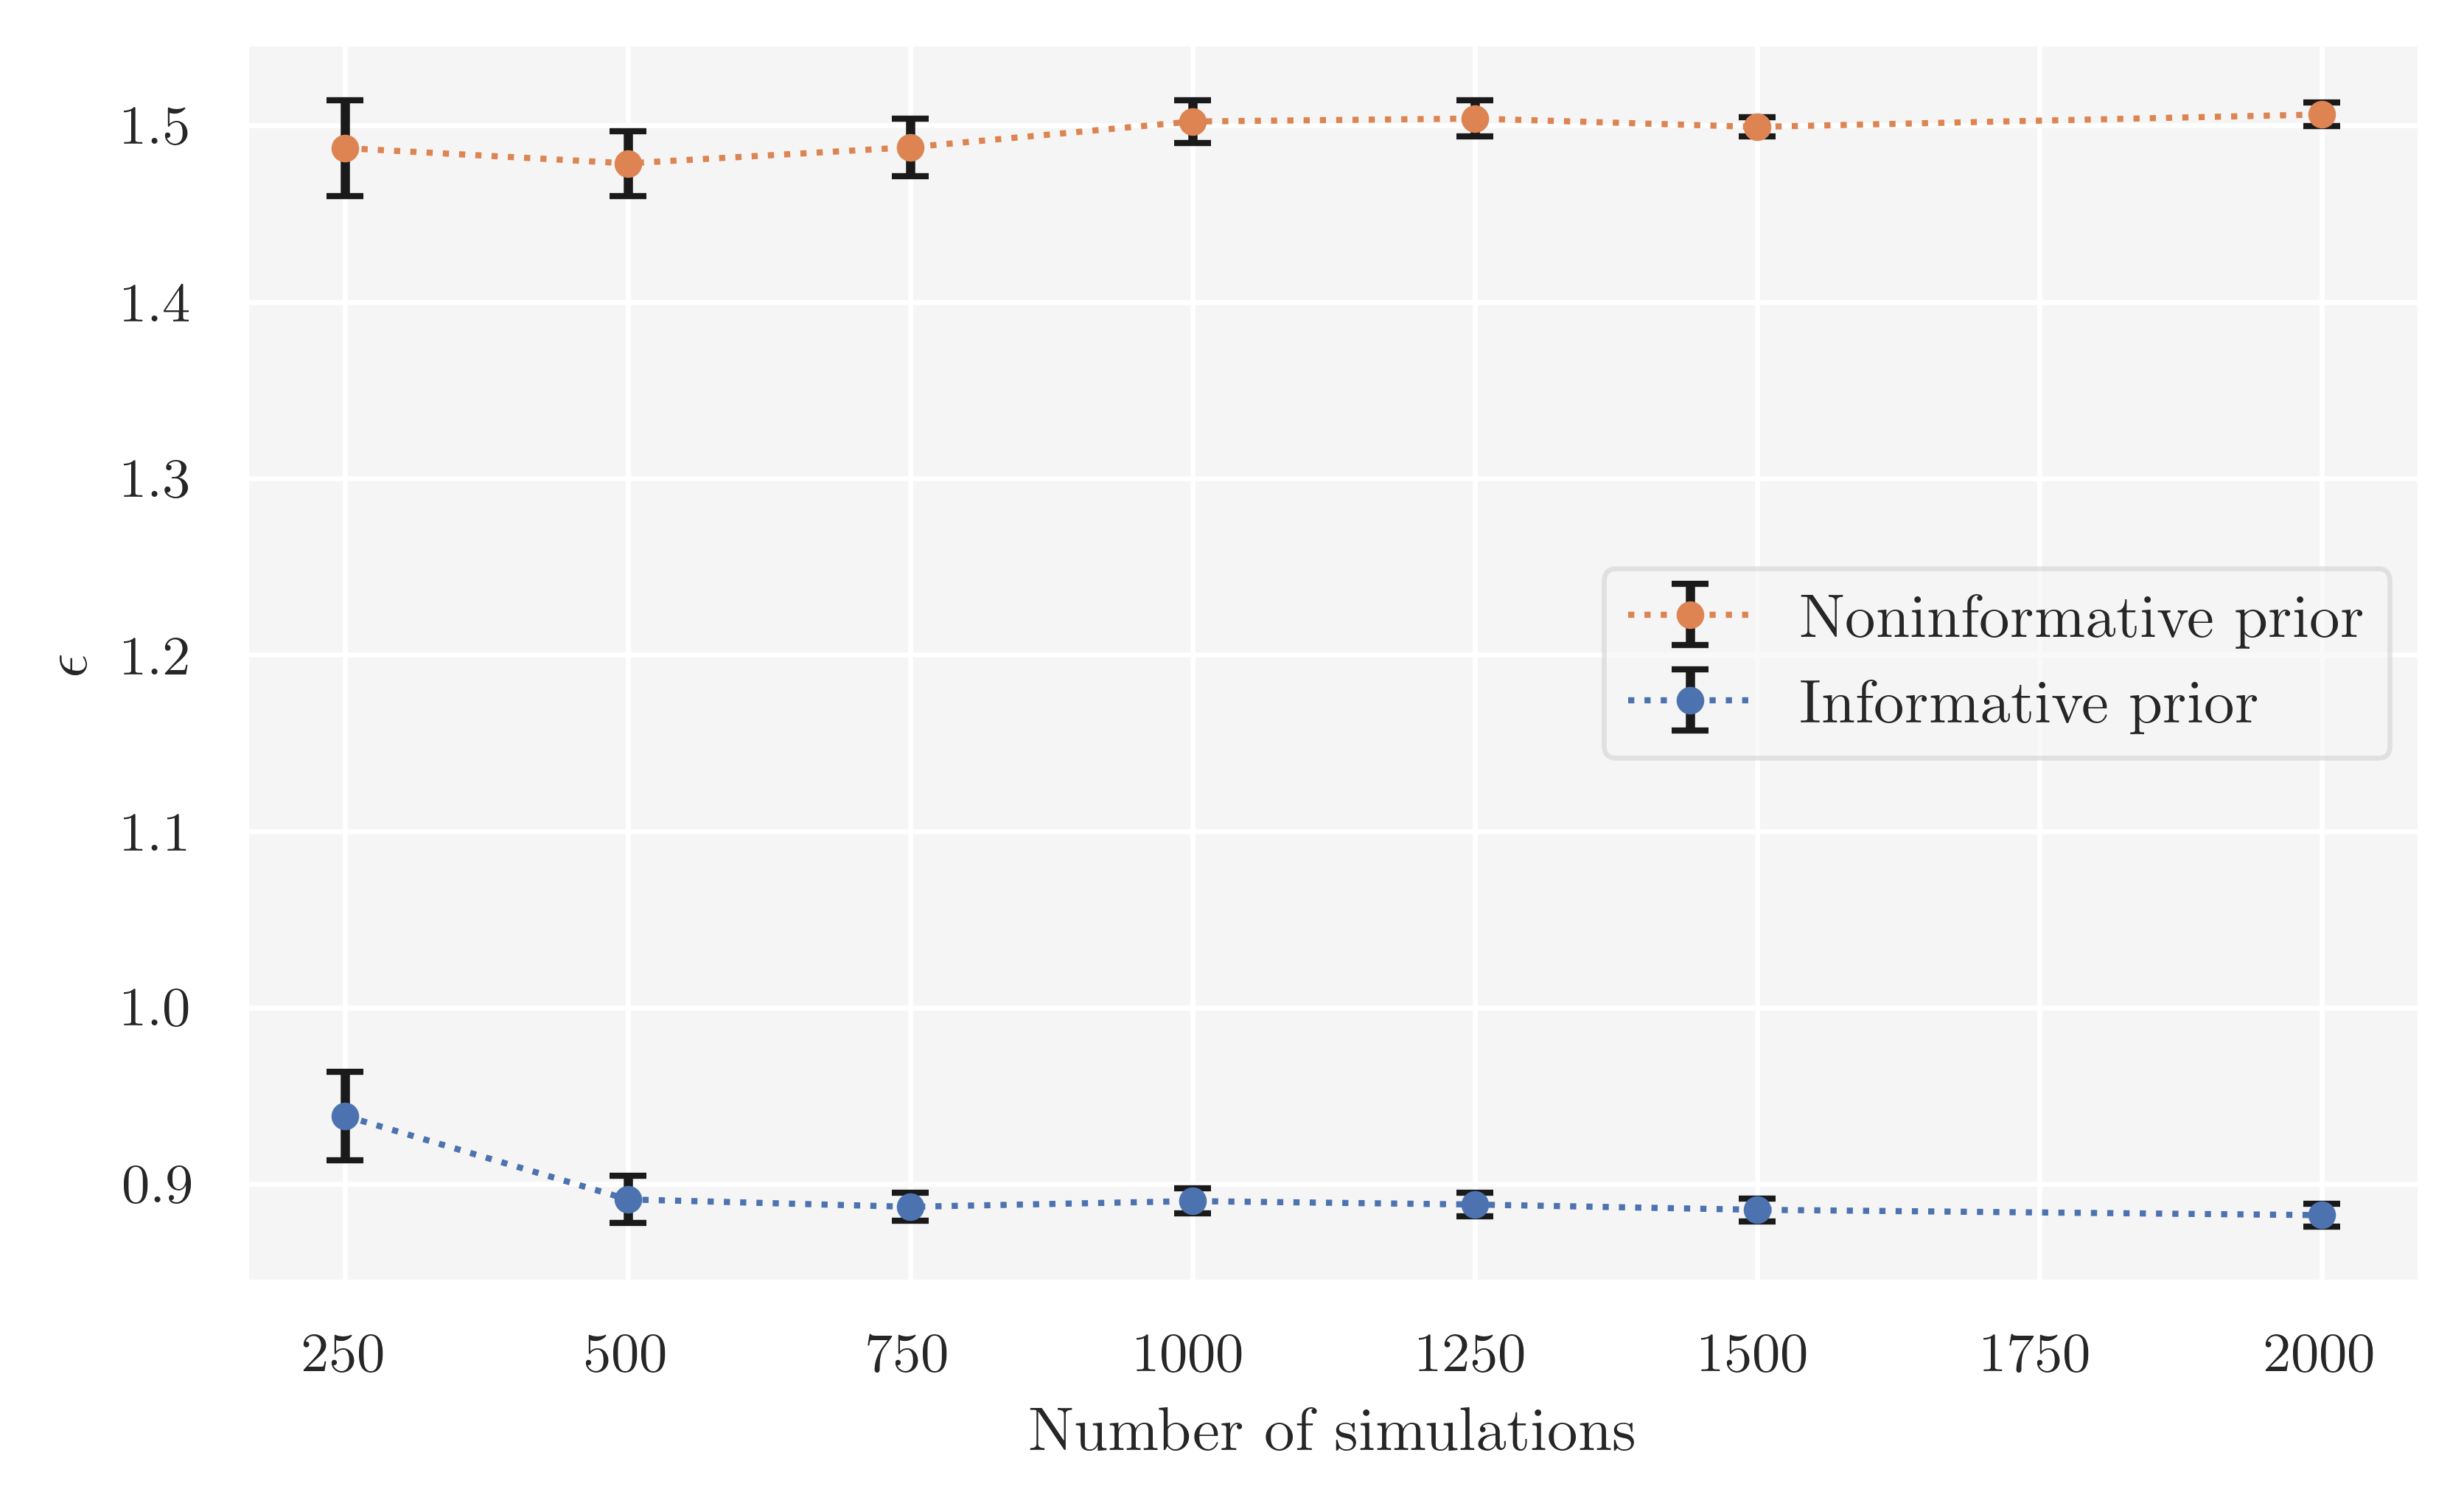

In [130]:
fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)

# normal prior
df_norm = pd.read_csv('data/pilot_eps_nsim_normal.csv')
x_norm = df_norm['n_sims'].unique()
mean_norm = df_norm.groupby('n_sims').mean().to_numpy().ravel()
sd_norm = df_norm.groupby('n_sims').sem().to_numpy().ravel() 

# uniform prior
df_unif = pd.read_csv('data/pilot_eps_nsim_uniform.csv')
x_unif = df_unif['n_sims'].unique()
mean_unif = df_unif.groupby('n_sims').mean().to_numpy().ravel()
sd_unif = df_unif.groupby('n_sims').sem().to_numpy().ravel()

ax.errorbar(x_unif, 
            mean_unif, 
            yerr=sd_unif, 
            fmt=':o', 
            color='C1',
            ecolor='k',
            markersize=3.5,
            lw=1.0, 
            elinewidth=1.5,
            capsize=3,
            label='Noninformative prior'
           )

ax.errorbar(x_norm, 
            mean_norm, 
            yerr=sd_norm, 
            fmt=':o', 
            color='C0',
            ecolor='k',
            markersize=3.5,
            lw=1.0, 
            elinewidth=1.5,
            capsize=3,
            label='Informative prior'
           ) 

ax.set(xlabel='Number of simulations',
       ylabel=r'$\epsilon$')
ax.legend(loc='center right', frameon=True, framealpha=0.5)
plt.show()

In [ ]:
plt.errorbar(x, y, yerr=dy, fmt='.k');

### RMSE vs quantile

RMSE averaged over 10 posteriors for each quantile value.

1000 posterior samples in each posterior

In [135]:
def sem(a, axis=0):
    """Standard error of the mean (SEM)"""
    return np.std(a) / np.sqrt(a.shape[axis])

def rmse(y_true, y_pred):
    """Root mean square error (RMSE)"""
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rmspe(y_true, y_pred):
    """Root mean square percentage error (RMSPE)"""
    rmspe = (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))) * 100
    return rmspe

In [141]:
# sanity check
y_true = 36 
y_pred = y_true * 1.1 # increase true value by 10%

# RMSPE should then be 10% 
print(rmspe(y_true, y_pred))

10.000000000000004


#### Normal prior

In [136]:
gbarK0 = 36.    # ground truth
gbarNa0 = 120.  # ground truth
gbarK_true = np.ones(1000) * gbarK0
gbarNa_true = np.ones(1000) * gbarNa0

path = 'data/'

# iterators
quantile_lst = [0.1, 0.3, 0.5, 0.7, 0.9]
trials = 10
N = len(quantile_lst)

# original posterior samples
gbarK_org_rmse_mean = np.zeros(N)
gbarK_org_rmse_sem = np.zeros(N)
gbarNa_org_rmse_mean = np.zeros(N)
gbarNa_org_rmse_sem = np.zeros(N)

# regression adjusted posterior samples
gbarK_reg_rmse_mean = np.zeros(N)
gbarK_reg_rmse_sem = np.zeros(N)
gbarNa_reg_rmse_mean = np.zeros(N)
gbarNa_reg_rmse_sem = np.zeros(N)

for i, quantile in enumerate(quantile_lst):
    quantile_str = str(quantile).replace('.', '_')
    
    # original posterior samples
    trial_gbarK_rmse_org = np.zeros(trials)
    trial_gbarNa_rmse_org = np.zeros(trials)
    
    # regression adjusted posterior samples
    trial_gbarK_rmse_reg = np.zeros(trials)
    trial_gbarNa_rmse_reg = np.zeros(trials)
    
    for trial in range(trials):
        # original posterior samples
        filename = f'hh_rej_normal_org_quantile_{quantile_str}_run_{trial}.jnl'
        journal = pylfi.Journal.load(path + filename)
        df = journal.df
        #trial_gbarK_rmse_org[trial] = rmse(gbarK_true, df["gbarK"].to_numpy())
        #trial_gbarNa_rmse_org[trial] = rmse(gbarNa_true, df["gbarNa"].to_numpy()) 
        trial_gbarK_rmse_org[trial] = rmspe(gbarK_true, df["gbarK"].to_numpy())
        trial_gbarNa_rmse_org[trial] = rmspe(gbarNa_true, df["gbarNa"].to_numpy()) 
        
        # regression adjusted posterior samples
        filename = f'hh_rej_normal_reg_quantile_{quantile_str}_run_{trial}.jnl'
        journal = pylfi.Journal.load(path + filename)
        df = journal.df
        trial_gbarK_rmse_reg[trial] = rmse(gbarK_true, df["gbarK"].to_numpy())
        trial_gbarNa_rmse_reg[trial] = rmse(gbarNa_true, df["gbarNa"].to_numpy()) 
        
    # Mean and SEM of RMSE samples
    # Original posterior
    gbarK_org_rmse_mean[i] = np.mean(trial_gbarK_rmse_org)
    gbarK_org_rmse_sem[i] = sem(trial_gbarK_rmse_org) 
    gbarNa_org_rmse_mean[i] = np.mean(trial_gbarNa_rmse_org)
    gbarNa_org_rmse_sem[i] = sem(trial_gbarNa_rmse_org) 
    
    # Adjusted posterior
    gbarK_reg_rmse_mean[i] = np.mean(trial_gbarK_rmse_reg)
    gbarK_reg_rmse_sem[i] = sem(trial_gbarK_rmse_reg) 
    gbarNa_reg_rmse_mean[i] = np.mean(trial_gbarNa_rmse_reg)
    gbarNa_reg_rmse_sem[i] = sem(trial_gbarNa_rmse_reg) 


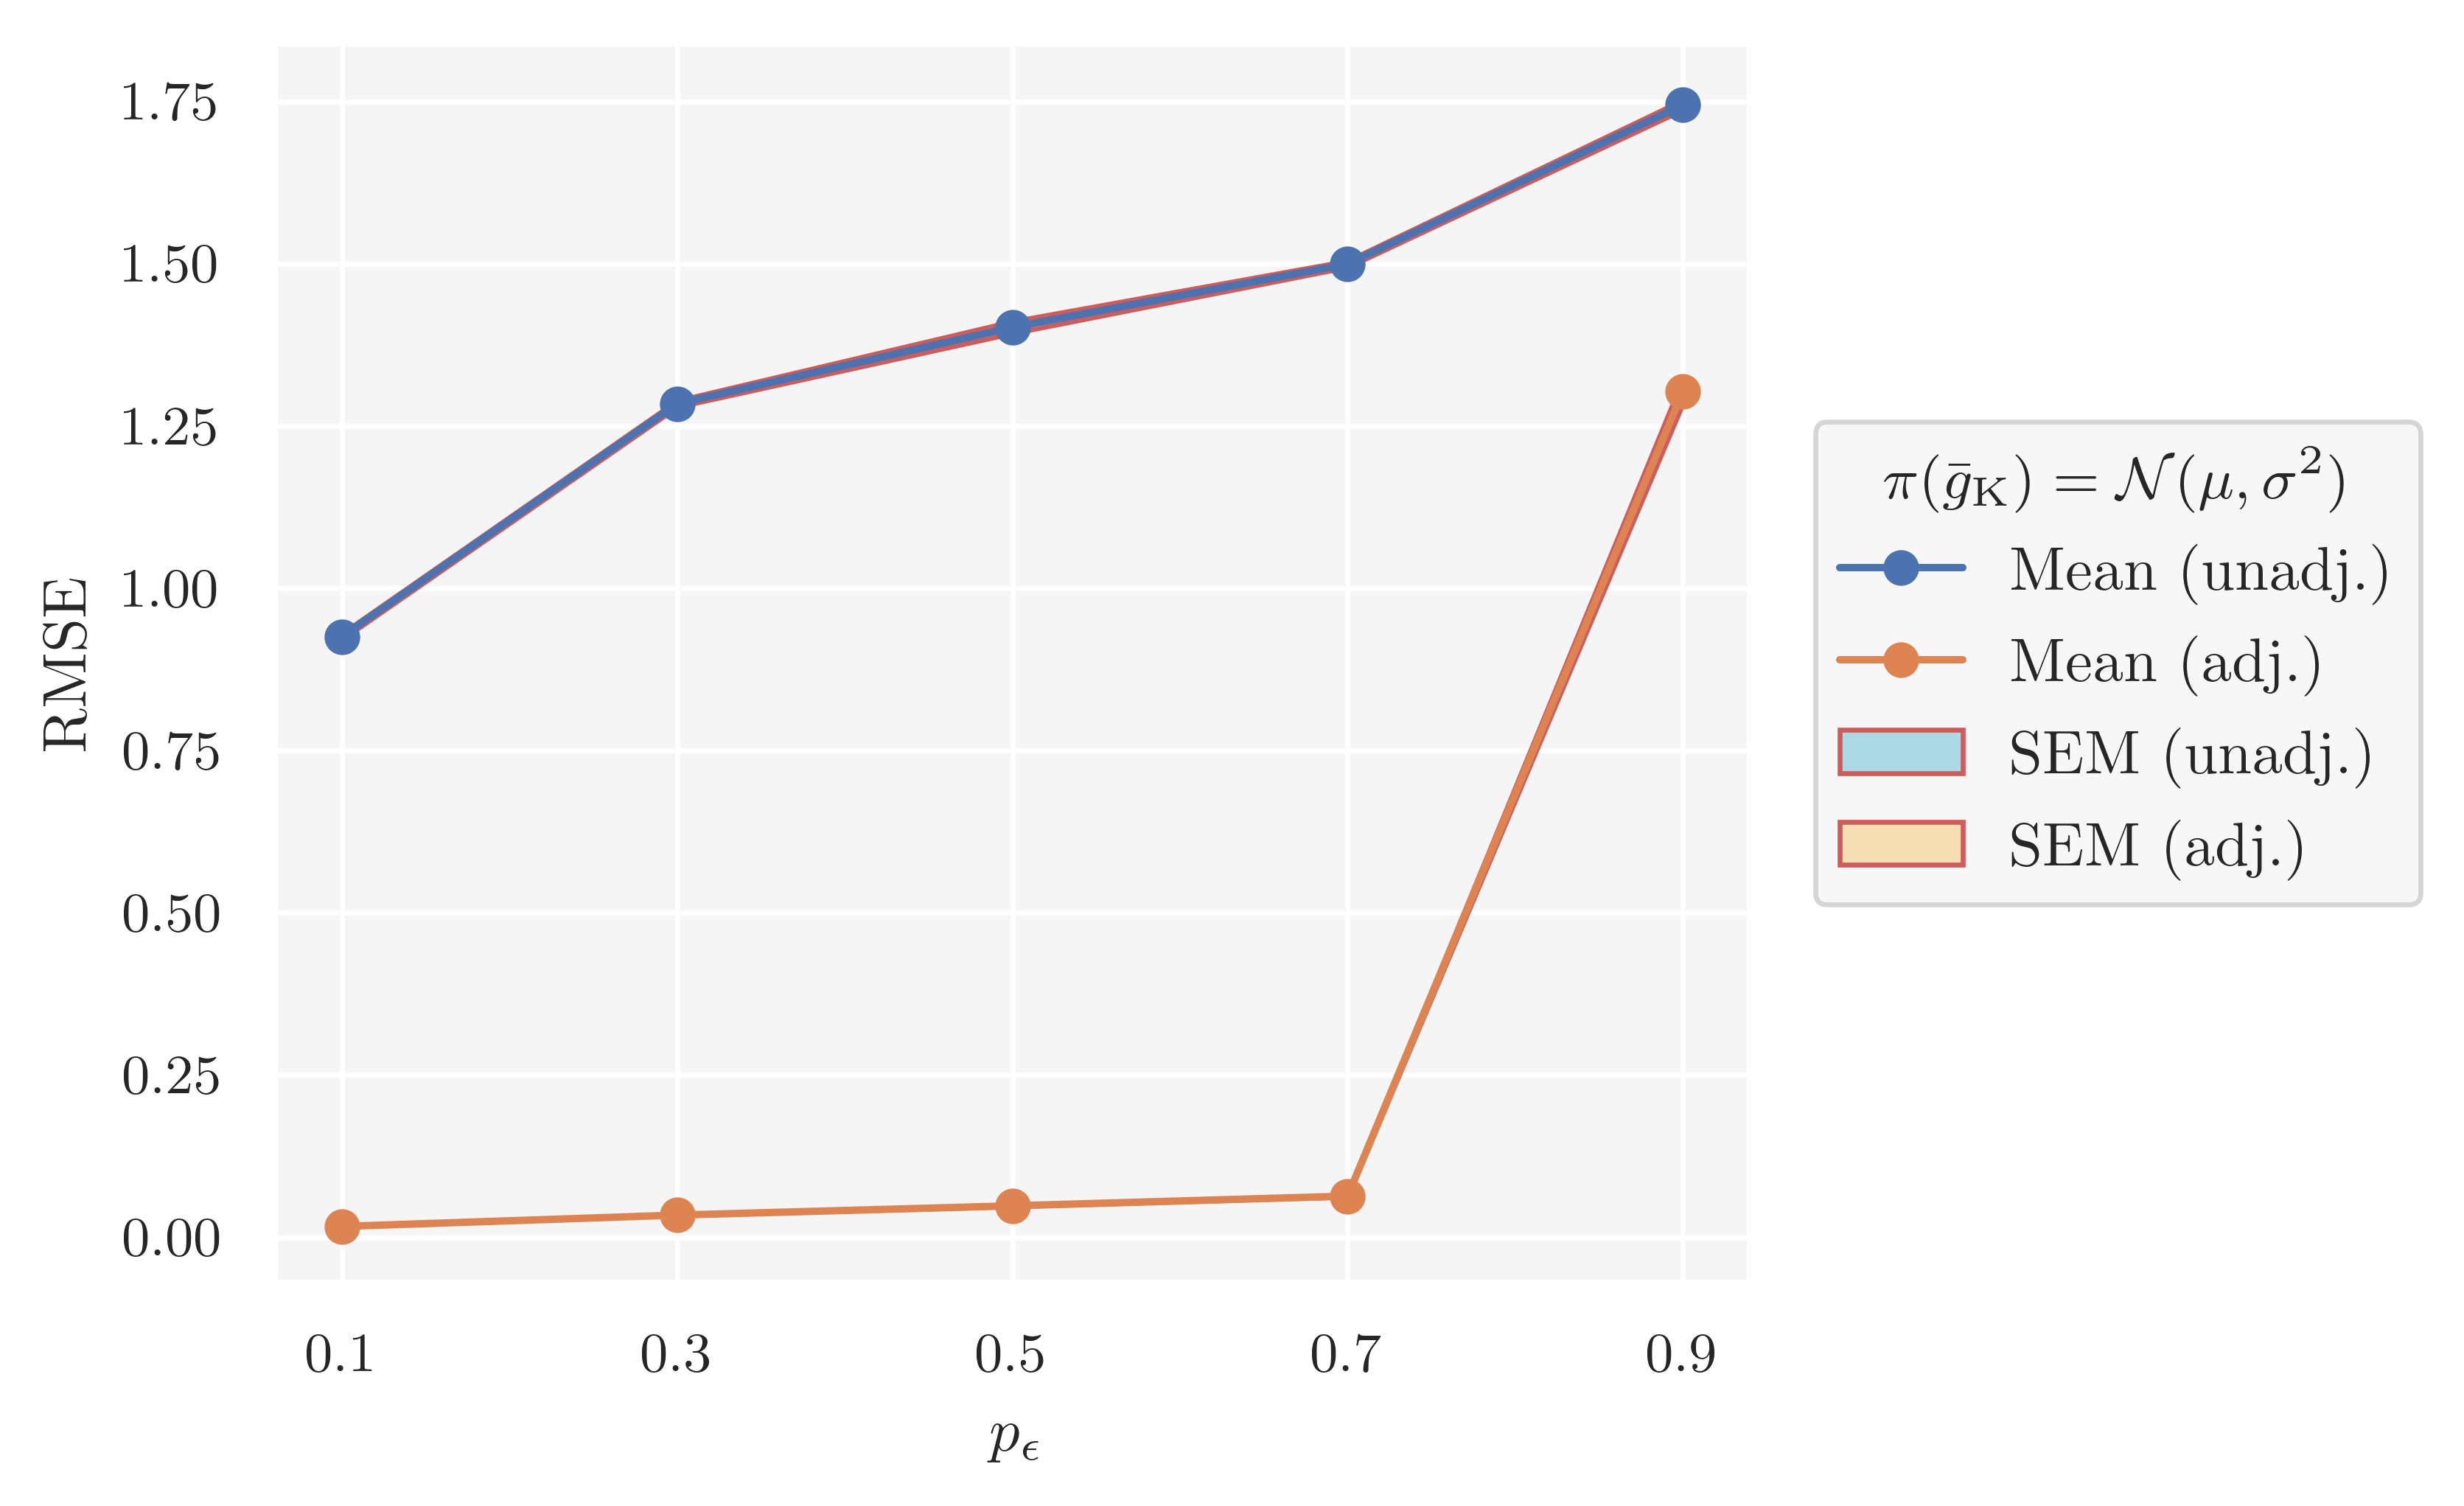

In [48]:
# gbarK

fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)
# original posterior samples
ax.plot(quantile_lst, 
        gbarK_org_rmse_mean, 
        '-o',
        label='Mean (unadj.)', 
        color='C0'
        )
ax.fill_between(quantile_lst, 
                gbarK_org_rmse_mean - gbarK_org_rmse_sem, 
                gbarK_org_rmse_mean + gbarK_org_rmse_sem,
                alpha=1.0,
                edgecolor='indianred',
                facecolor='lightblue',
                lw=0.5,
                label='SEM (unadj.)'
                )
# regression adjusted posterior samples
ax.plot(quantile_lst, 
        gbarK_reg_rmse_mean, 
        '-o', 
        label='Mean (adj.)', 
        color='C1'
        )
ax.fill_between(quantile_lst, 
                gbarK_reg_rmse_mean - gbarK_reg_rmse_sem, 
                gbarK_reg_rmse_mean + gbarK_reg_rmse_sem,
                alpha=1.0,
                edgecolor='indianred',
                facecolor='wheat',
                lw=0.5,
                label='SEM (adj.)'
                )

ax.set(xticks=quantile_lst,
       xlabel=r'$p_{\epsilon}$',
       ylabel="RMSE",
       )
ax.legend()

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles,
          labels,
          loc='center left',
          bbox_to_anchor=(1.04, 0.5),
          fancybox=True,
          borderaxespad=0.1,
          ncol=1,
          title=r'$\bar{g}_\mathrm{K}$'
         )
 
fig.savefig(fig_path('rmse_quantile_gbarK_normal.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

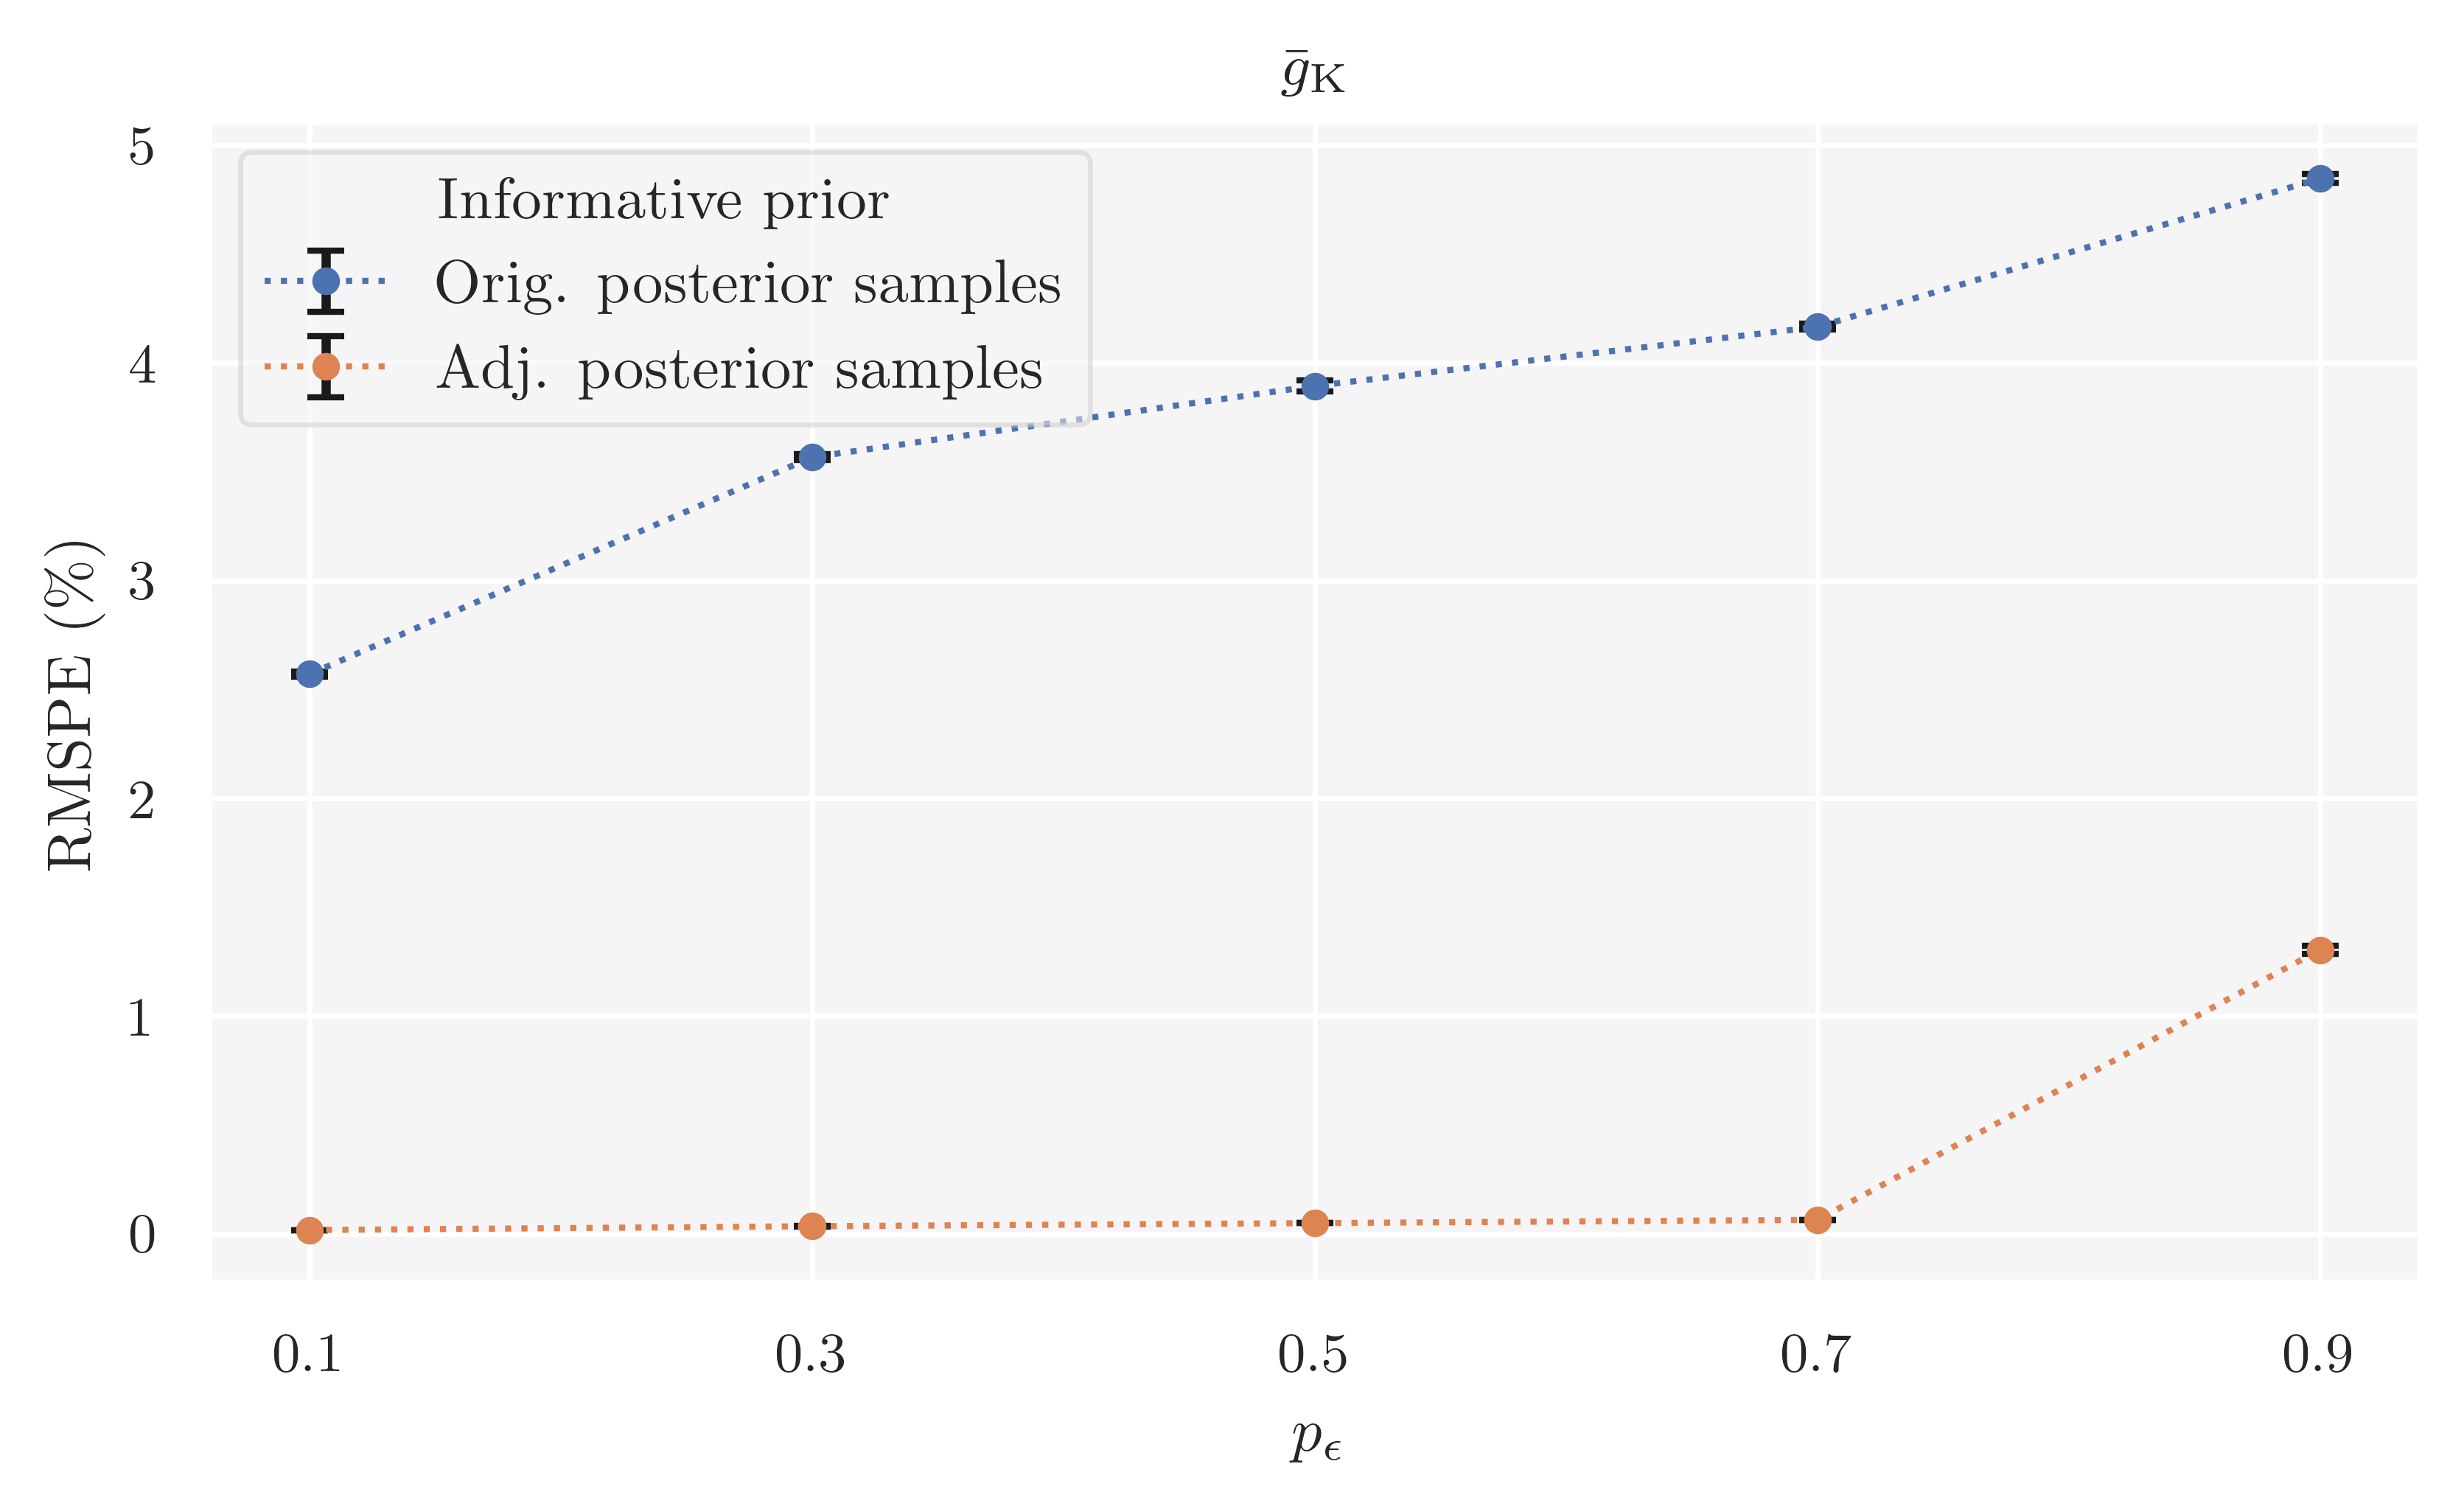

In [146]:
fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)
ax.errorbar(quantile_lst, 
            gbarK_org_rmse_mean, 
            yerr=gbarK_org_rmse_sem, 
            fmt=':o', 
            color='C0',
            ecolor='k',
            markersize=3.5,
            lw=1.0, 
            elinewidth=1.5,
            capsize=3,
            label='Orig. posterior samples'
           ) 
                
ax.errorbar(quantile_lst, 
            gbarK_reg_rmse_mean, 
            yerr=gbarK_reg_rmse_sem, 
            fmt=':o', 
            color='C1',
            ecolor='k',
            markersize=3.5,
            lw=1.0, 
            elinewidth=1.5,
            capsize=3,
            label='Adj. posterior samples'
           ) 

ax.set(xticks=quantile_lst,
       xlabel=r'$p_{\epsilon}$',
       ylabel="RMSPE (\%)",
       title=r'$\bar{g}_\mathrm{K}$'
       )
ax.legend(title='Informative prior', loc='upper left', frameon=True, framealpha=0.5)
plt.show()

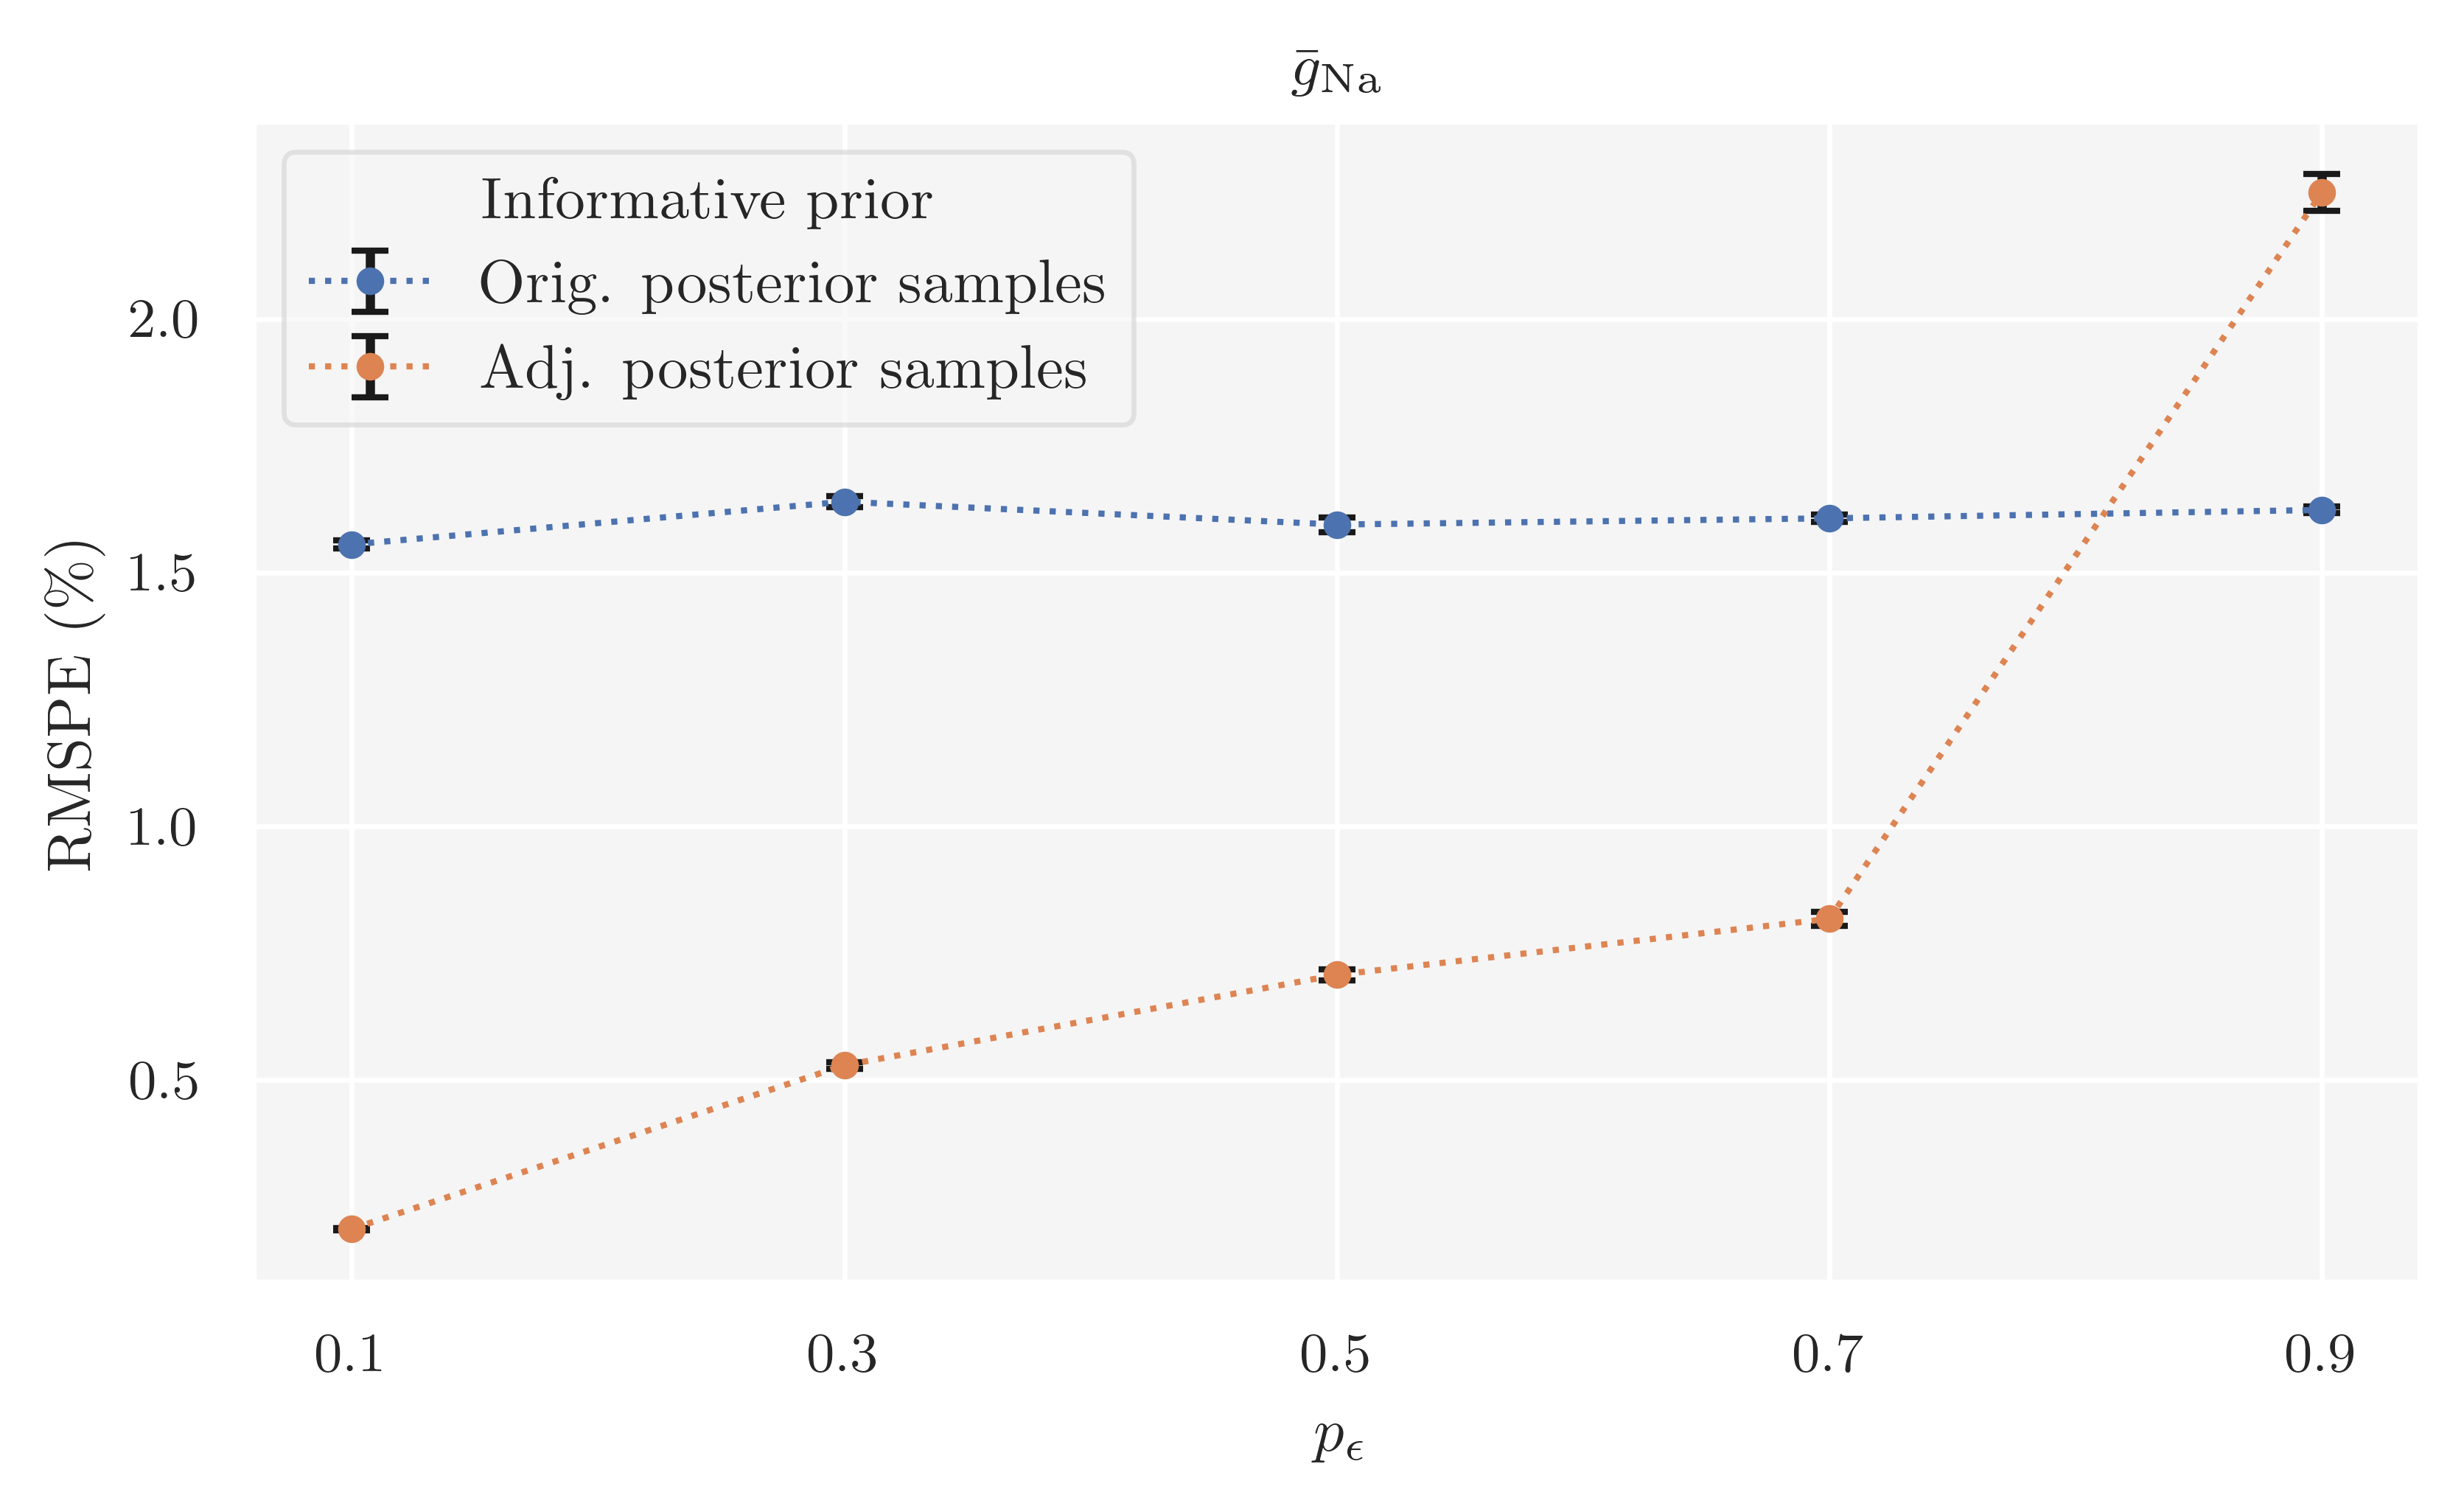

In [147]:
fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)
ax.errorbar(quantile_lst, 
            gbarNa_org_rmse_mean, 
            yerr=gbarNa_org_rmse_sem, 
            fmt=':o', 
            color='C0',
            ecolor='k',
            markersize=3.5,
            lw=1.0, 
            elinewidth=1.5,
            capsize=3,
            label='Orig. posterior samples'
           ) 
                
ax.errorbar(quantile_lst, 
            gbarNa_reg_rmse_mean, 
            yerr=gbarNa_reg_rmse_sem, 
            fmt=':o', 
            color='C1',
            ecolor='k',
            markersize=3.5,
            lw=1.0, 
            elinewidth=1.5,
            capsize=3,
            label='Adj. posterior samples'
           ) 

ax.set(xticks=quantile_lst,
       xlabel=r'$p_{\epsilon}$',
       ylabel="RMSPE (\%)",
       title=r'$\bar{g}_\mathrm{Na}$'
       )
ax.legend(title='Informative prior', loc='upper left', frameon=True, framealpha=0.5)
plt.show()

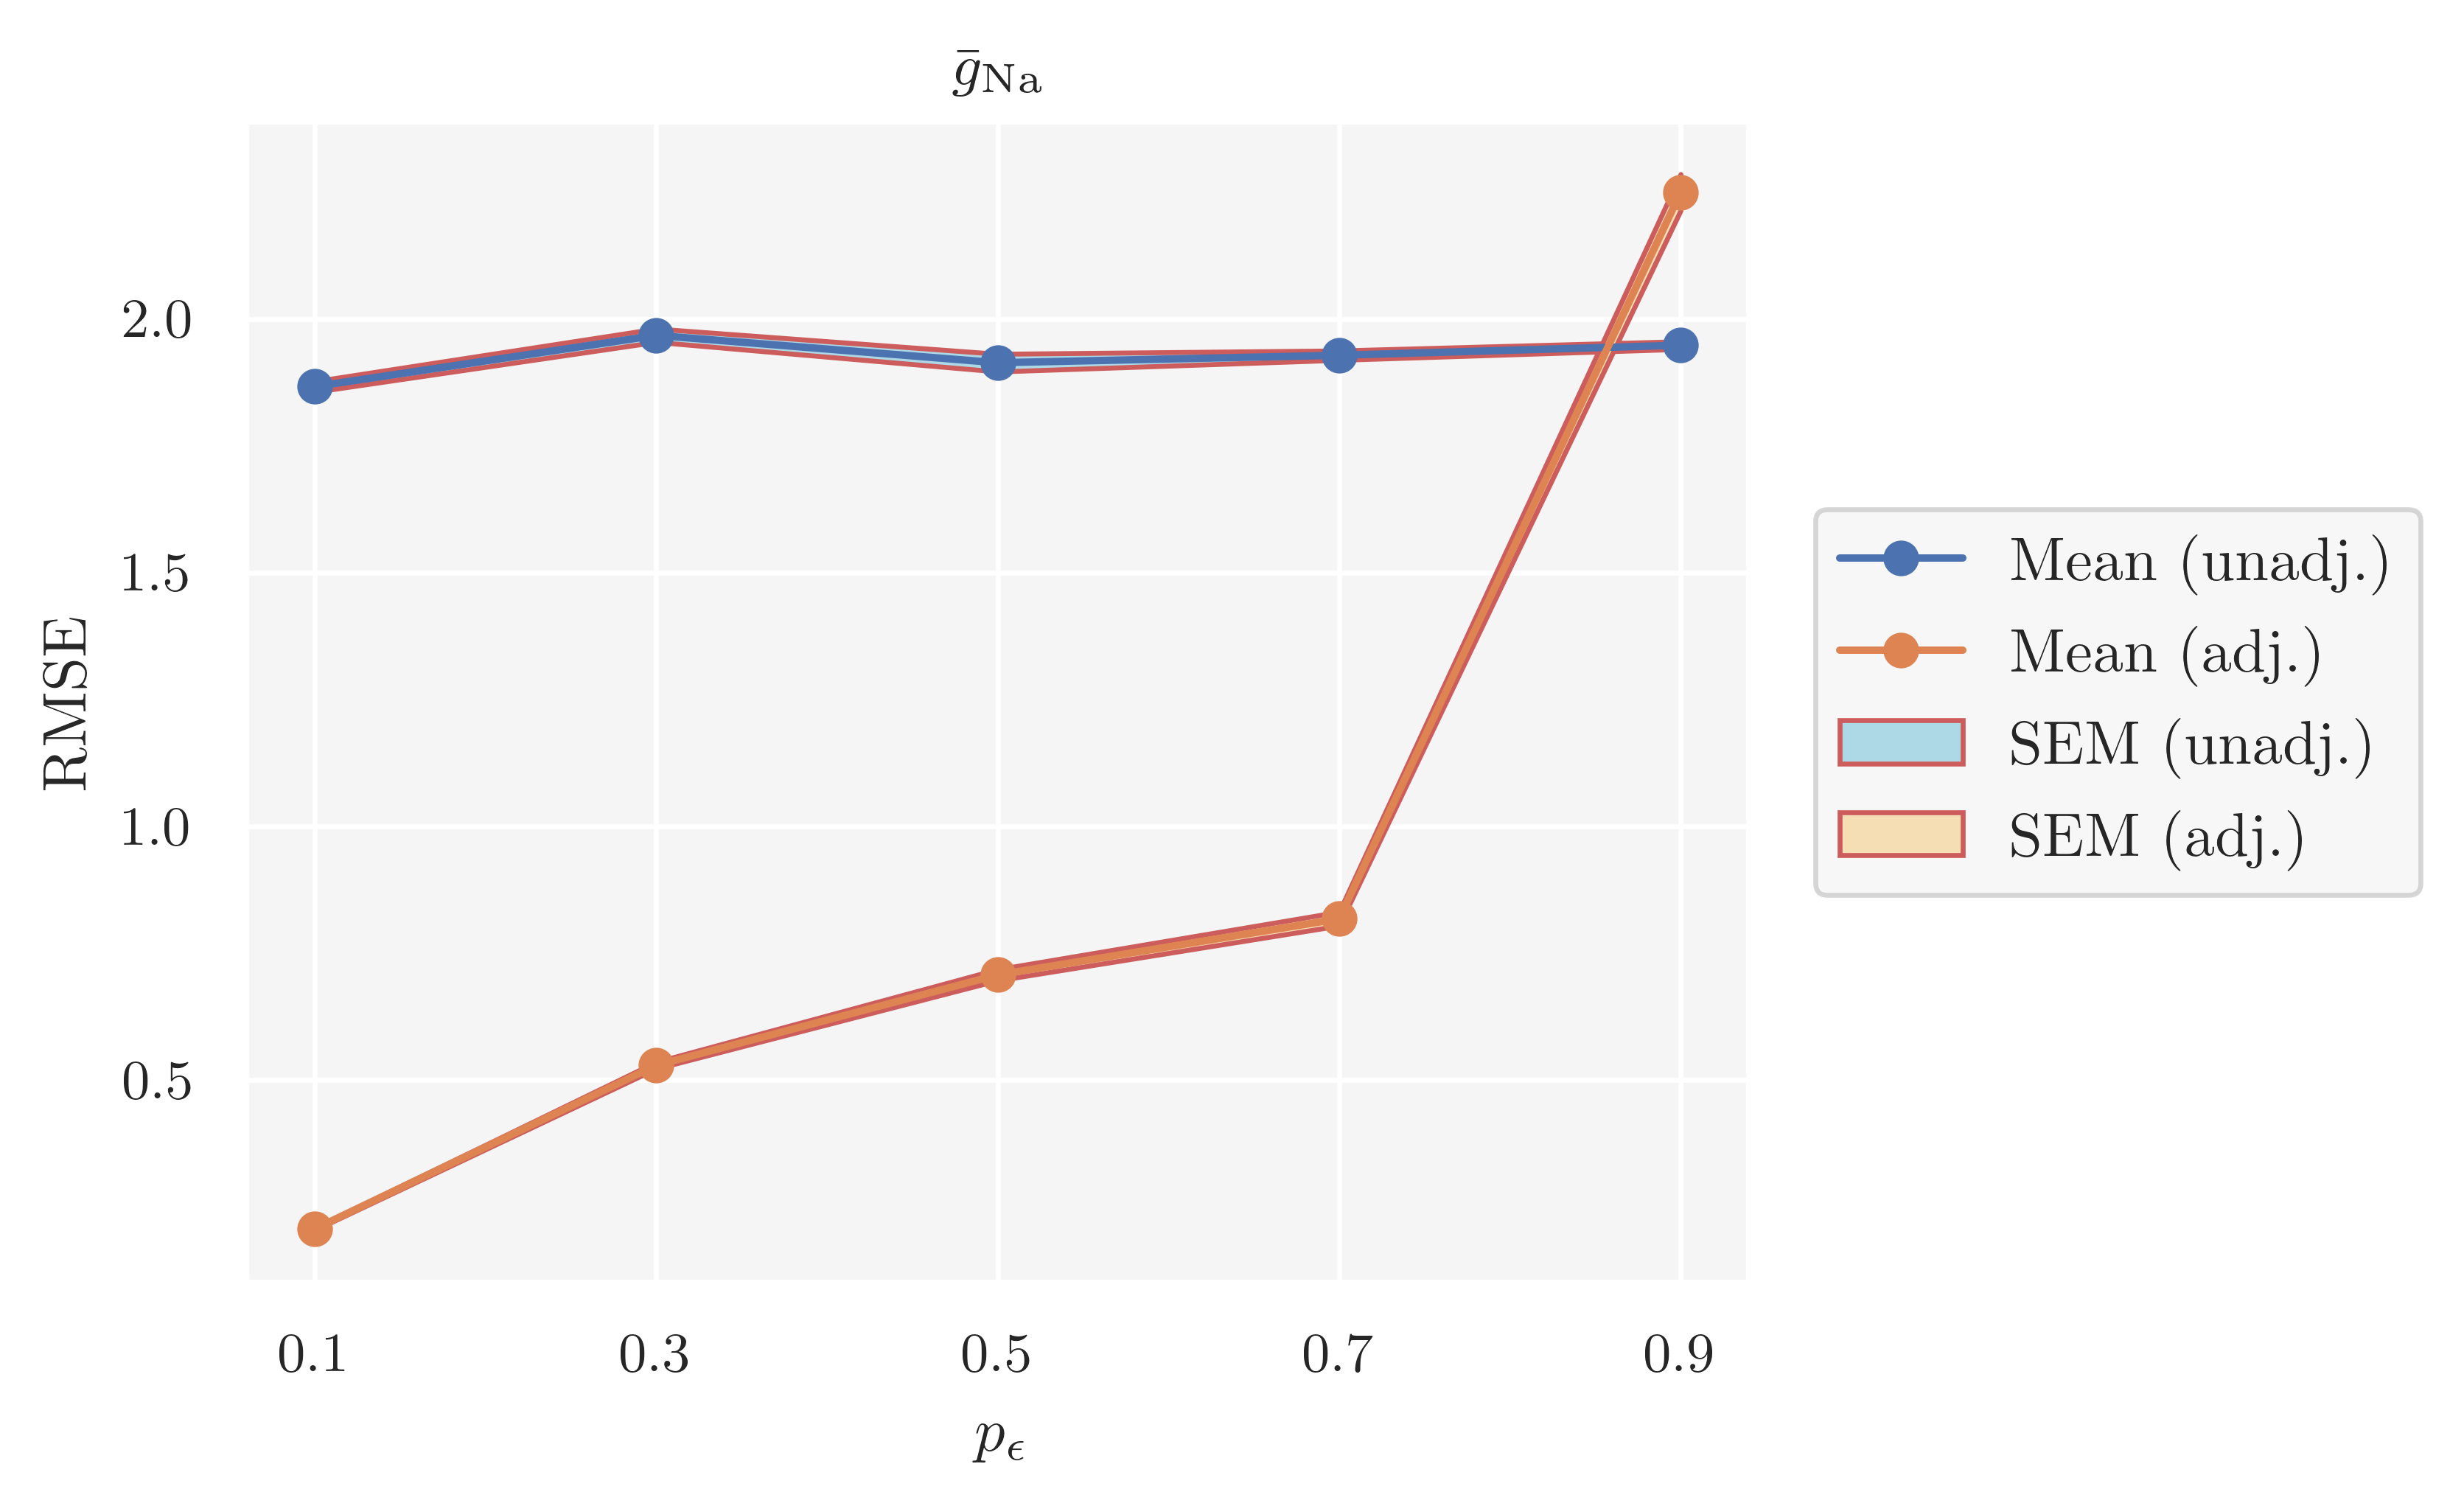

In [49]:
# gbarNa

fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)
# original posterior samples
ax.scatter()
ax.plot(quantile_lst, 
        gbarNa_org_rmse_mean, 
        '-o',
        label='Mean (unadj.)', 
        color='C0'
        )
ax.fill_between(quantile_lst, 
                gbarNa_org_rmse_mean - gbarNa_org_rmse_sem, 
                gbarNa_org_rmse_mean + gbarNa_org_rmse_sem,
                alpha=1.0,
                edgecolor='indianred',
                facecolor='lightblue',
                lw=0.5,
                label='SEM (unadj.)'
                )
# regression adjusted posterior samples
ax.plot(quantile_lst, 
        gbarNa_reg_rmse_mean, 
        '-o', 
        label='Mean (adj.)', 
        color='C1'
        )
ax.fill_between(quantile_lst, 
                gbarNa_reg_rmse_mean - gbarNa_reg_rmse_sem, 
                gbarNa_reg_rmse_mean + gbarNa_reg_rmse_sem,
                alpha=1.0,
                edgecolor='indianred',
                facecolor='wheat',
                lw=0.5,
                label='SEM (adj.)'
                )

ax.set(xticks=quantile_lst,
       xlabel=r'$p_{\epsilon}$',
       ylabel="RMSE",
       title=r'$\bar{g}_\mathrm{Na}$'
       )
ax.legend()

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles,
          labels,
          loc='center left',
          bbox_to_anchor=(1.04, 0.5),
          fancybox=True,
          borderaxespad=0.1,
          ncol=1
         )
 
fig.savefig(fig_path('rmse_quantile_gbarNa_normal.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

Summary statistics seem to be more sensitive to the values of $\bar{g}_\mathrm{K}$ than $\bar{g}_\mathrm{Na}$, this observation is supported by the RMSE of the regression adjusted posterior samples (the correction depends on the relationship between parameter and summary statistics). 

The 0.5-quantile seems to be a good tradeoff between sampling and computational efficiency (0.5-quantile means that we accept approximately 50% of the simulations)

#### Uniform prior 

In [50]:
gbarK0 = 36.    # ground truth
gbarNa0 = 120.  # ground truth
gbarK_true = np.ones(1000) * gbarK0
gbarNa_true = np.ones(1000) * gbarNa0

path = 'data/'

# iterators
quantile_lst = [0.1, 0.3, 0.5, 0.7, 0.9]
trials = 10
N = len(quantile_lst)

# original posterior samples
gbarK_org_rmse_mean = np.zeros(N)
gbarK_org_rmse_sem = np.zeros(N)
gbarNa_org_rmse_mean = np.zeros(N)
gbarNa_org_rmse_sem = np.zeros(N)

# regression adjusted posterior samples
gbarK_reg_rmse_mean = np.zeros(N)
gbarK_reg_rmse_sem = np.zeros(N)
gbarNa_reg_rmse_mean = np.zeros(N)
gbarNa_reg_rmse_sem = np.zeros(N)

for i, quantile in enumerate(quantile_lst):
    quantile_str = str(quantile).replace('.', '_')
    
    # original posterior samples
    trial_gbarK_rmse_org = np.zeros(trials)
    trial_gbarNa_rmse_org = np.zeros(trials)
    
    # regression adjusted posterior samples
    trial_gbarK_rmse_reg = np.zeros(trials)
    trial_gbarNa_rmse_reg = np.zeros(trials)
    
    for trial in range(trials):
        # original posterior samples
        filename = f'hh_rej_uniform_org_quantile_{quantile_str}_run_{trial}.jnl'
        journal = pylfi.Journal.load(path + filename)
        df = journal.df
        trial_gbarK_rmse_org[trial] = rmse(gbarK_true, df["gbarK"].to_numpy())
        trial_gbarNa_rmse_org[trial] = rmse(gbarNa_true, df["gbarNa"].to_numpy()) 
        
        # regression adjusted posterior samples
        filename = f'hh_rej_uniform_reg_quantile_{quantile_str}_run_{trial}.jnl'
        journal = pylfi.Journal.load(path + filename)
        df = journal.df
        trial_gbarK_rmse_reg[trial] = rmse(gbarK_true, df["gbarK"].to_numpy())
        trial_gbarNa_rmse_reg[trial] = rmse(gbarNa_true, df["gbarNa"].to_numpy()) 
        
    # Mean and SEM of RMSE samples
    # Original posterior
    gbarK_org_rmse_mean[i] = np.mean(trial_gbarK_rmse_org)
    gbarK_org_rmse_sem[i] = sem(trial_gbarK_rmse_org) 
    gbarNa_org_rmse_mean[i] = np.mean(trial_gbarNa_rmse_org)
    gbarNa_org_rmse_sem[i] = sem(trial_gbarNa_rmse_org) 
    
    # Adjusted posterior
    gbarK_reg_rmse_mean[i] = np.mean(trial_gbarK_rmse_reg)
    gbarK_reg_rmse_sem[i] = sem(trial_gbarK_rmse_reg) 
    gbarNa_reg_rmse_mean[i] = np.mean(trial_gbarNa_rmse_reg)
    gbarNa_reg_rmse_sem[i] = sem(trial_gbarNa_rmse_reg) 

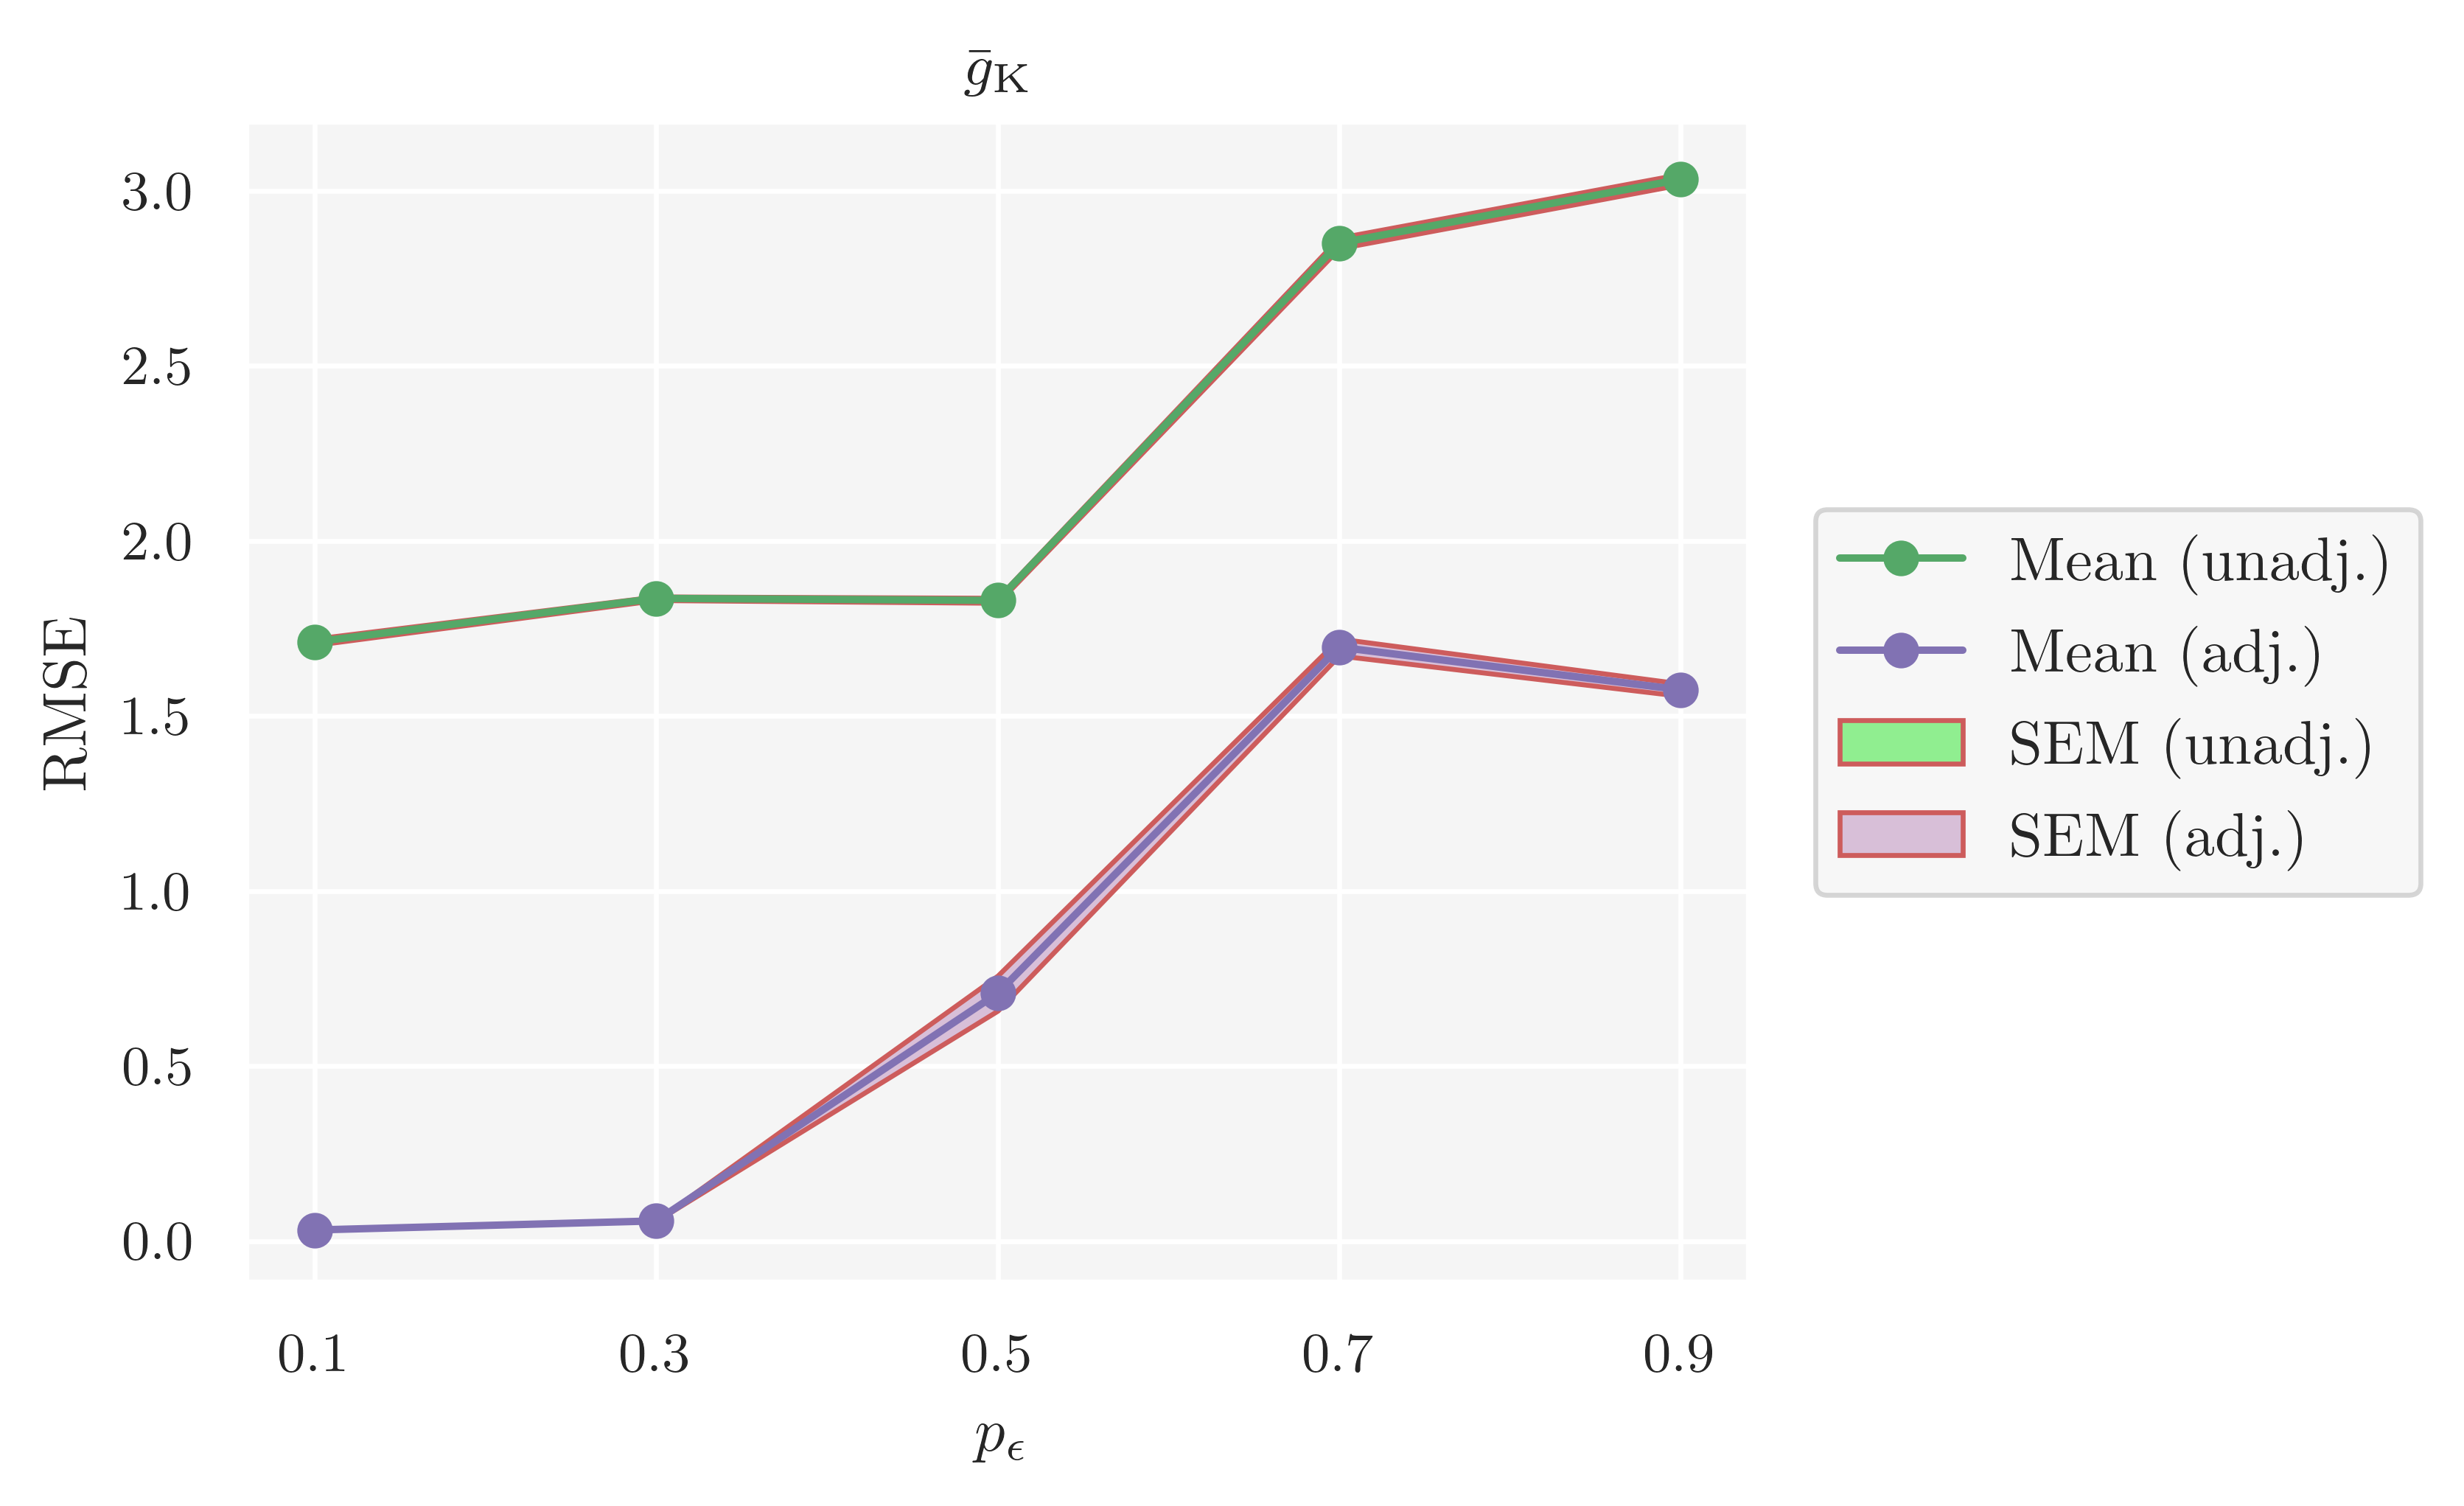

In [51]:
# gbarK

fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)
# original posterior samples
ax.plot(quantile_lst, 
        gbarK_org_rmse_mean, 
        '-o',
        label='Mean (unadj.)', 
        color='C2'
        )
ax.fill_between(quantile_lst, 
                gbarK_org_rmse_mean - gbarK_org_rmse_sem, 
                gbarK_org_rmse_mean + gbarK_org_rmse_sem,
                alpha=1.0,
                edgecolor='indianred',
                facecolor='lightgreen',
                lw=0.5,
                label='SEM (unadj.)'
                )
# regression adjusted posterior samples
ax.plot(quantile_lst, 
        gbarK_reg_rmse_mean, 
        '-o', 
        label='Mean (adj.)', 
        color='C4'
        )
ax.fill_between(quantile_lst, 
                gbarK_reg_rmse_mean - gbarK_reg_rmse_sem, 
                gbarK_reg_rmse_mean + gbarK_reg_rmse_sem,
                alpha=1.0,
                edgecolor='indianred',
                facecolor='thistle',
                lw=0.5,
                label='SEM (adj.)'
                )

ax.set(xticks=quantile_lst,
       xlabel=r'$p_{\epsilon}$',
       ylabel="RMSE",
       title=r'$\bar{g}_\mathrm{K}$'
       )
ax.legend()

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles,
          labels,
          loc='center left',
          bbox_to_anchor=(1.04, 0.5),
          fancybox=True,
          borderaxespad=0.1,
          ncol=1
         )
 
fig.savefig(fig_path('rmse_quantile_gbarK_uniform.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

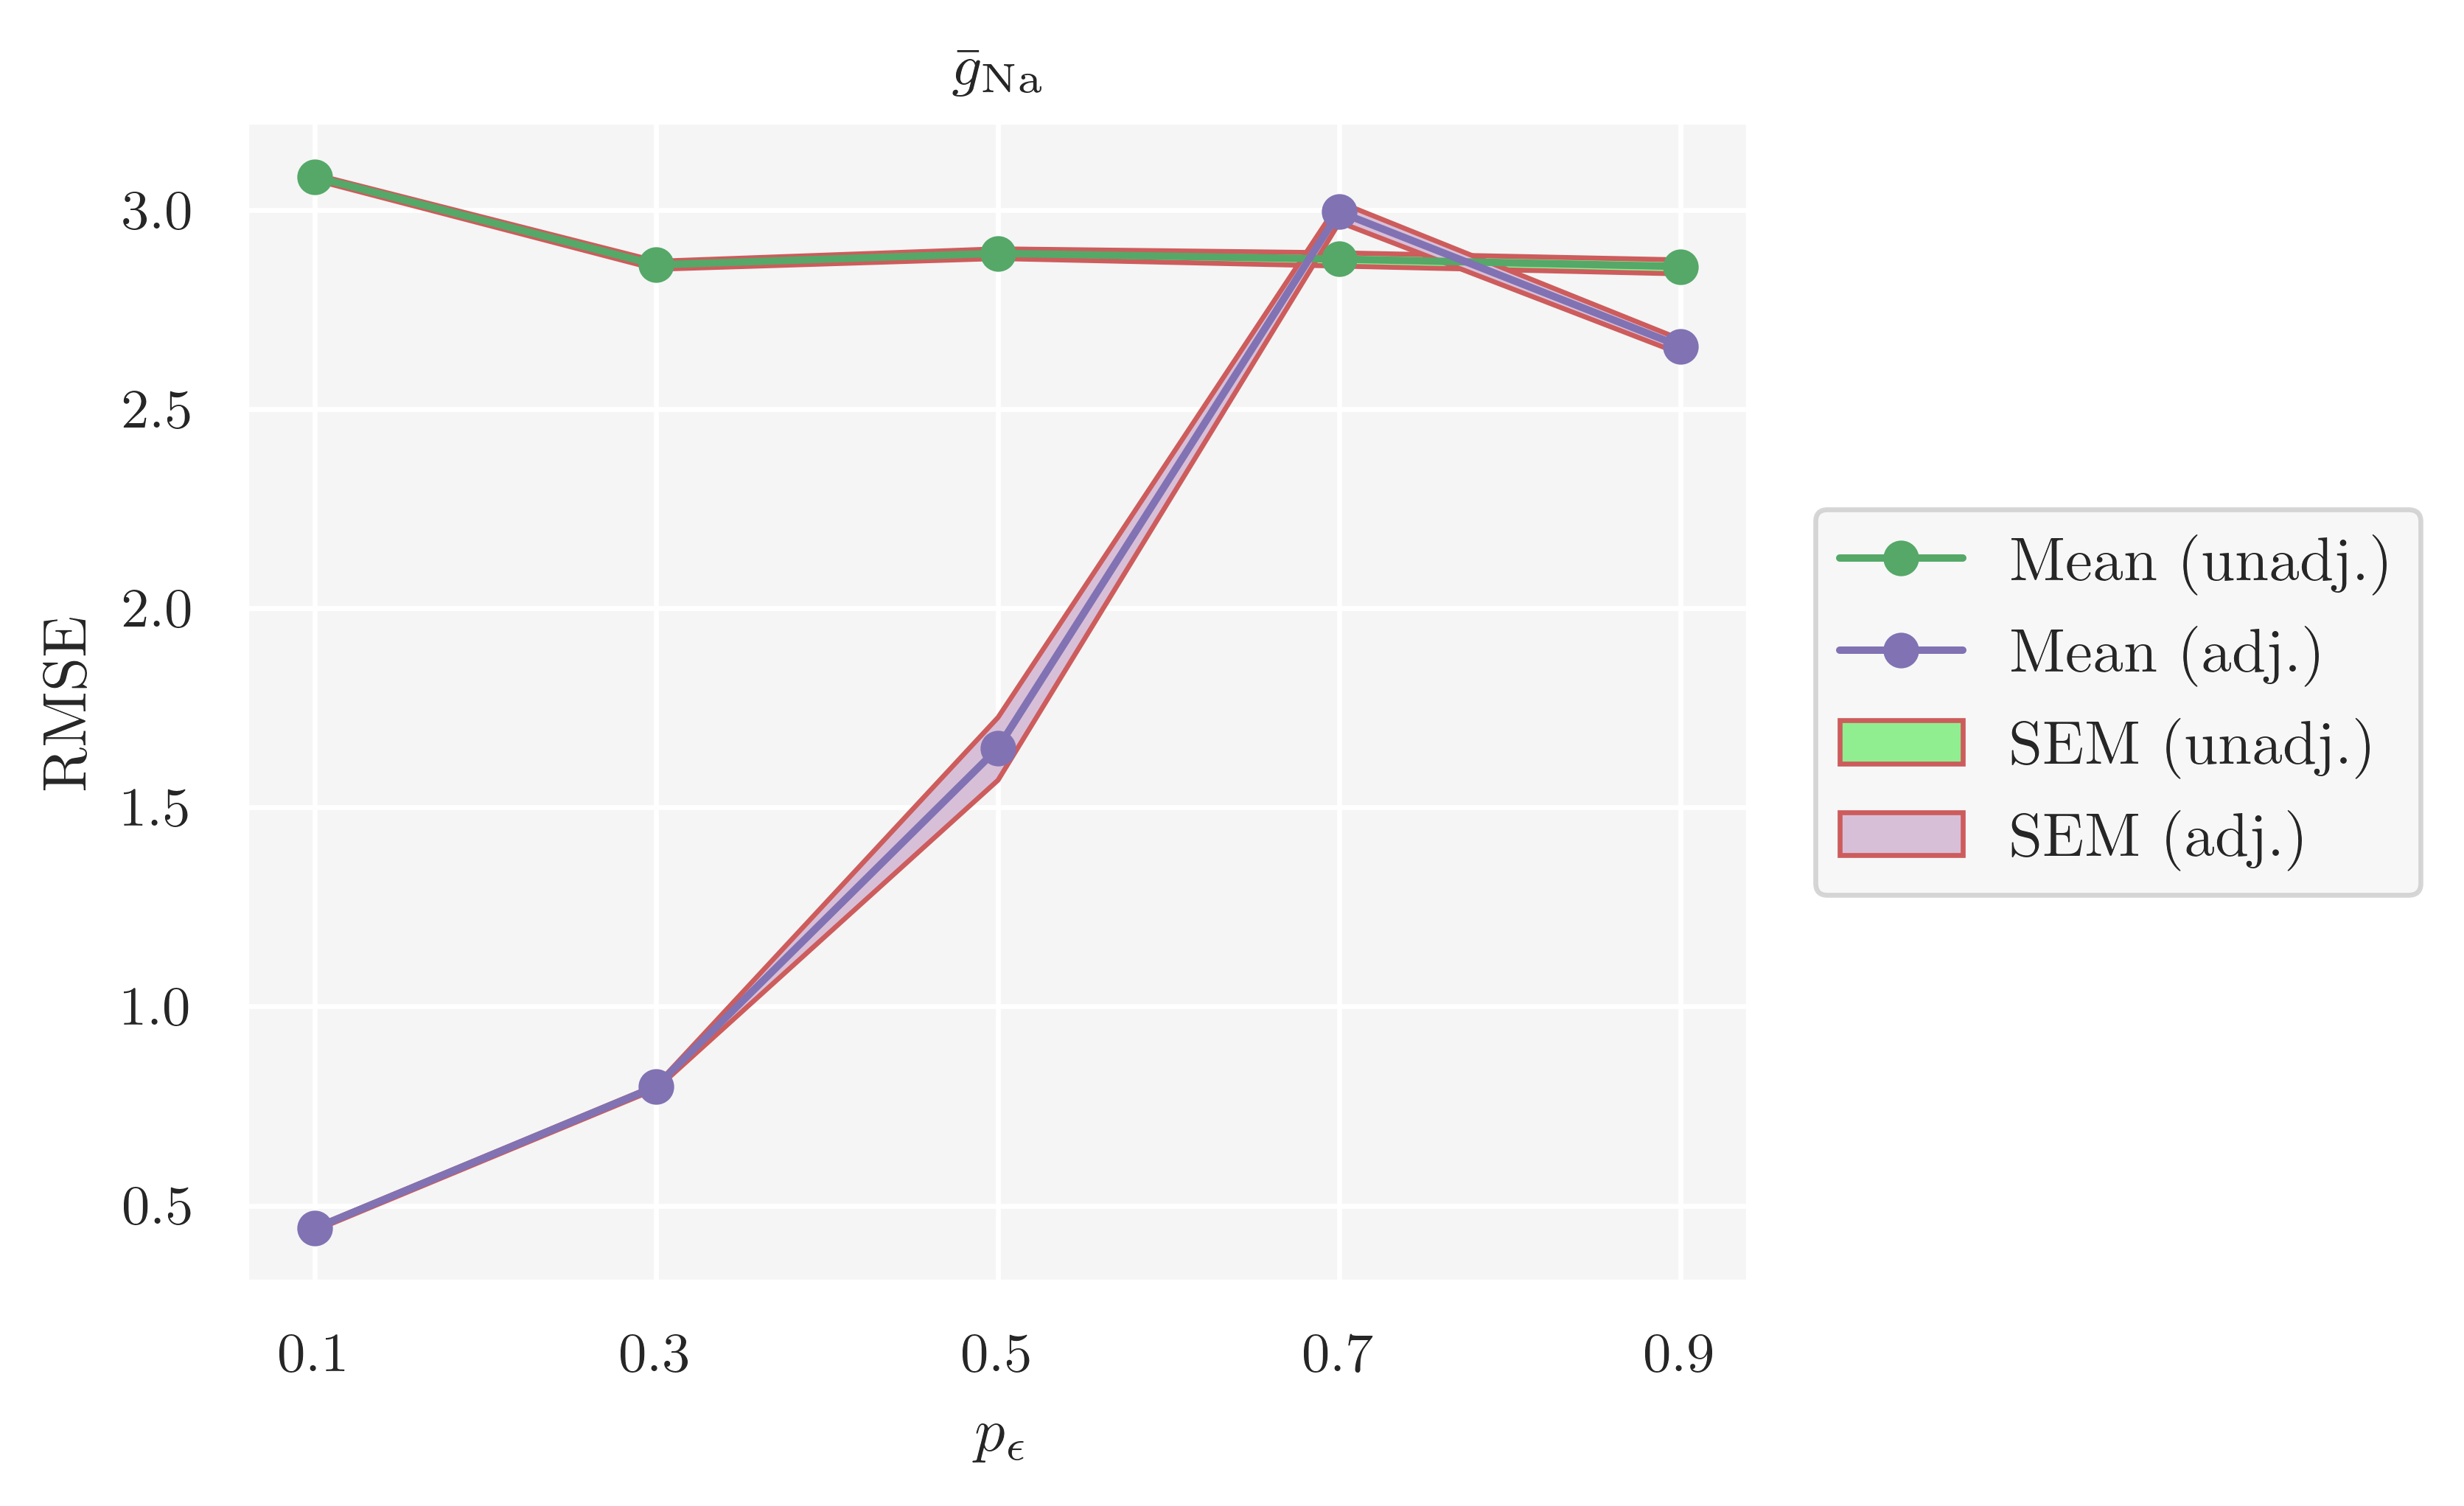

In [52]:
# gbarNa

fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)
# original posterior samples
ax.plot(quantile_lst, 
        gbarNa_org_rmse_mean, 
        '-o',
        label='Mean (unadj.)', 
        color='C2'
        )
ax.fill_between(quantile_lst, 
                gbarNa_org_rmse_mean - gbarNa_org_rmse_sem, 
                gbarNa_org_rmse_mean + gbarNa_org_rmse_sem,
                alpha=1.0,
                edgecolor='indianred',
                facecolor='lightgreen',
                lw=0.5,
                label='SEM (unadj.)'
                )
# regression adjusted posterior samples
ax.plot(quantile_lst, 
        gbarNa_reg_rmse_mean, 
        '-o', 
        label='Mean (adj.)', 
        color='C4'
        )
ax.fill_between(quantile_lst, 
                gbarNa_reg_rmse_mean - gbarNa_reg_rmse_sem, 
                gbarNa_reg_rmse_mean + gbarNa_reg_rmse_sem,
                alpha=1.0,
                edgecolor='indianred',
                facecolor='thistle',
                lw=0.5,
                label='SEM (adj.)'
                )

ax.set(xticks=quantile_lst,
       xlabel=r'$p_{\epsilon}$',
       ylabel="RMSE",
       title=r'$\bar{g}_\mathrm{Na}$'
       )

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles,
          labels,
          loc='center left',
          bbox_to_anchor=(1.04, 0.5),
          fancybox=True,
          borderaxespad=0.1,
          ncol=1
         )
 
fig.savefig(fig_path('rmse_quantile_gbarNa_uniform.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

### Computational time

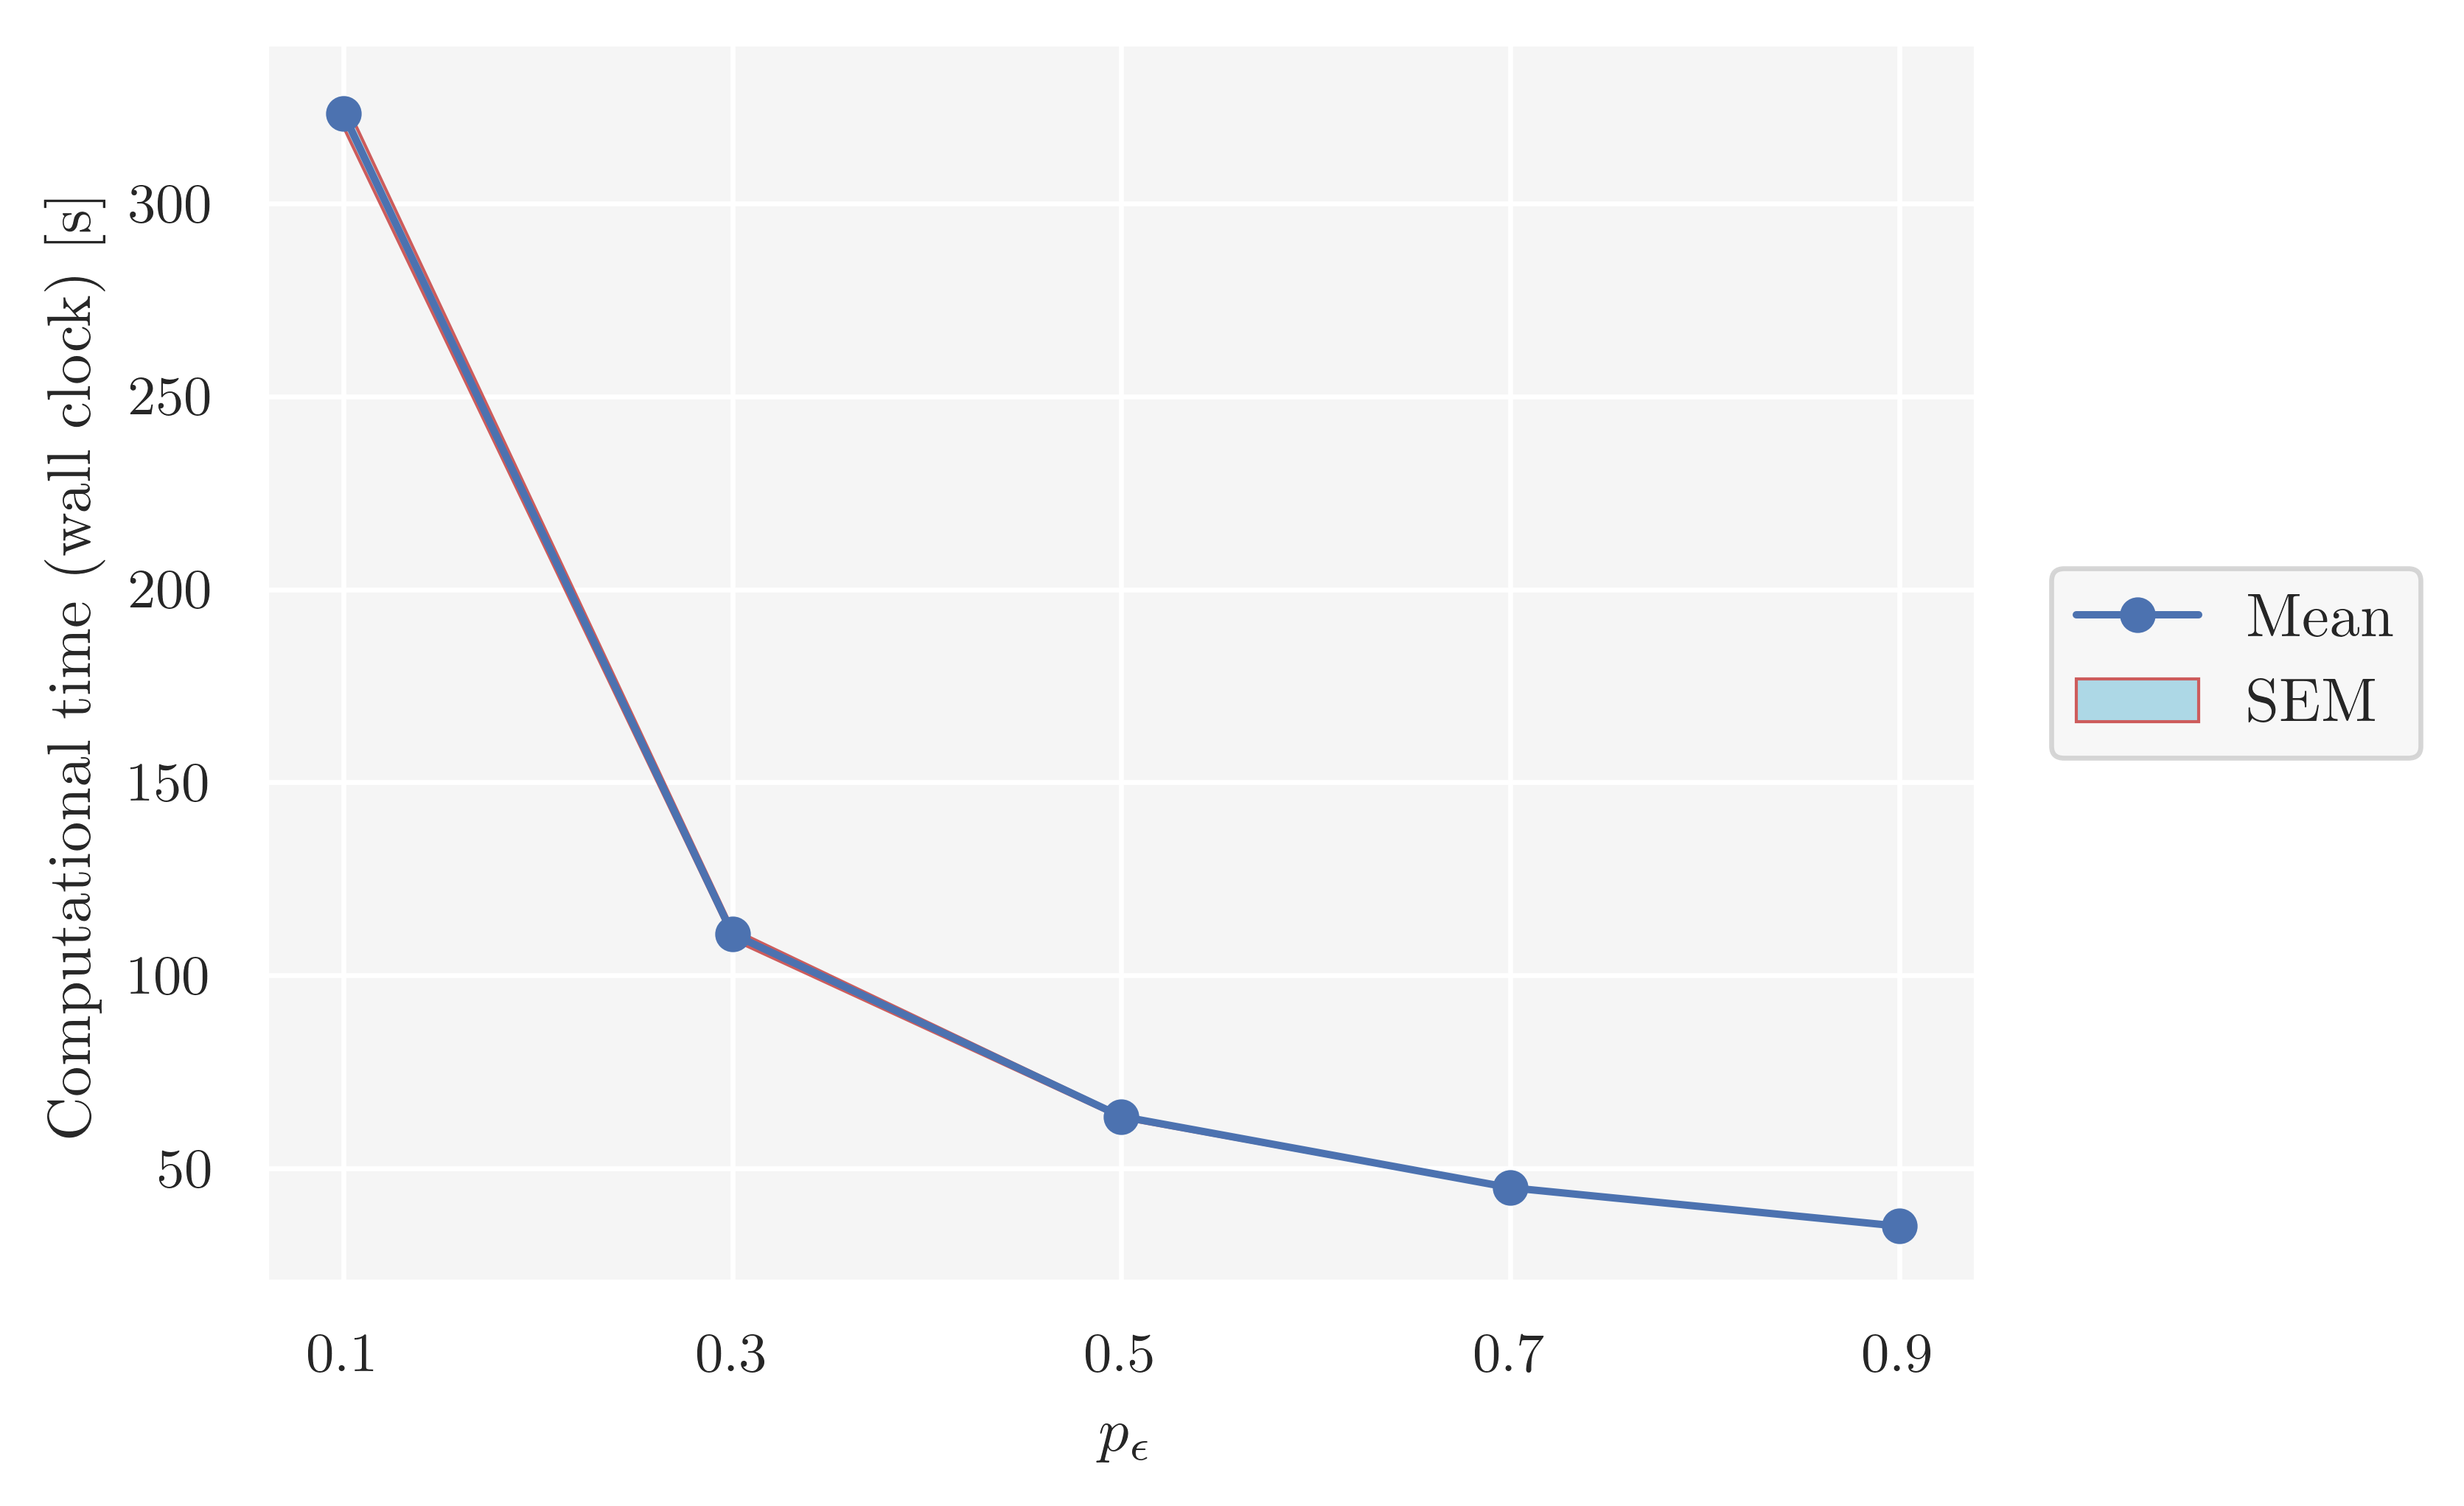

In [77]:
fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)

# normal prior
df_norm = pd.read_csv('data/run_time_quantile.csv')
x_norm = df_norm['quantile'].unique()
mean_norm = df_norm.groupby('quantile').mean().to_numpy().ravel()
sd_norm = df_norm.groupby('quantile').sem().to_numpy().ravel() 

ax.plot(x_norm, 
        mean_norm,
        '-o', 
        label=r'Mean', 
        color='C0'
       )
 
ax.fill_between(x_norm, 
                mean_norm - sd_norm, 
                mean_norm + sd_norm,
                alpha=1.0,
                edgecolor='indianred',
                facecolor='lightblue',
                lw=0.5,
                label=r'SEM'
                )

ax.set(xticks=quantile_lst,
       xlabel=r'$p_{\epsilon}$',
       ylabel="Computational time (wall clock) [s]",
       )

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles,
          labels,
          loc='center left',
          bbox_to_anchor=(1.04, 0.5),
          fancybox=True,
          borderaxespad=0.1,
          ncol=1
         )

fig.savefig(fig_path('comp_time_quantile.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

Sampling 1000 posterior samples with different quantile-based thresholds. Consistent computational times. 

Can find a trade-off between computational speed and accuracy (RMSE) (the prior information plays a role here)

Not a rigorous time benchmark, just meant to provide an illustration of the trade-off.

### RMSE vs number of posterior samples

p-quantile = 0.4 

pilot study: 2000 simulations 

3 summary statistics

#### Normal prior

In [65]:
gbarK0 = 36.    # ground truth
gbarNa0 = 120.  # ground truth

path = 'data/'

# iterators
nsamples_lst = [200, 500, 1000, 1500, 2000]
trials = 10
N = len(quantile_lst)

# original posterior samples
gbarK_org_rmse_mean = np.zeros(N)
gbarK_org_rmse_sem = np.zeros(N)
gbarNa_org_rmse_mean = np.zeros(N)
gbarNa_org_rmse_sem = np.zeros(N)

# regression adjusted posterior samples
gbarK_reg_rmse_mean = np.zeros(N)
gbarK_reg_rmse_sem = np.zeros(N)
gbarNa_reg_rmse_mean = np.zeros(N)
gbarNa_reg_rmse_sem = np.zeros(N)

for i, nsamples in enumerate(nsamples_lst):
    
    gbarK_true = np.ones(nsamples) * gbarK0
    gbarNa_true = np.ones(nsamples) * gbarNa0
    
    # original posterior samples
    trial_gbarK_rmse_org = np.zeros(trials)
    trial_gbarNa_rmse_org = np.zeros(trials)
    
    # regression adjusted posterior samples
    trial_gbarK_rmse_reg = np.zeros(trials)
    trial_gbarNa_rmse_reg = np.zeros(trials)
    
    for trial in range(trials):
        # original posterior samples
        filename = f'hh_rej_normal_org_nsamples_{nsamples}_run_{trial}.jnl'
        journal = pylfi.Journal.load(path + filename)
        df = journal.df
        trial_gbarK_rmse_org[trial] = rmse(gbarK_true, df["gbarK"].to_numpy())
        trial_gbarNa_rmse_org[trial] = rmse(gbarNa_true, df["gbarNa"].to_numpy()) 
        
        # regression adjusted posterior samples
        filename = f'hh_rej_normal_reg_nsamples_{nsamples}_run_{trial}.jnl'
        journal = pylfi.Journal.load(path + filename)
        df = journal.df
        trial_gbarK_rmse_reg[trial] = rmse(gbarK_true, df["gbarK"].to_numpy())
        trial_gbarNa_rmse_reg[trial] = rmse(gbarNa_true, df["gbarNa"].to_numpy()) 
        
    # Mean and SEM of RMSE samples
    # Original posterior
    gbarK_org_rmse_mean[i] = np.mean(trial_gbarK_rmse_org)
    gbarK_org_rmse_sem[i] = sem(trial_gbarK_rmse_org) 
    gbarNa_org_rmse_mean[i] = np.mean(trial_gbarNa_rmse_org)
    gbarNa_org_rmse_sem[i] = sem(trial_gbarNa_rmse_org) 
    
    # Adjusted posterior
    gbarK_reg_rmse_mean[i] = np.mean(trial_gbarK_rmse_reg)
    gbarK_reg_rmse_sem[i] = sem(trial_gbarK_rmse_reg) 
    gbarNa_reg_rmse_mean[i] = np.mean(trial_gbarNa_rmse_reg)
    gbarNa_reg_rmse_sem[i] = sem(trial_gbarNa_rmse_reg) 

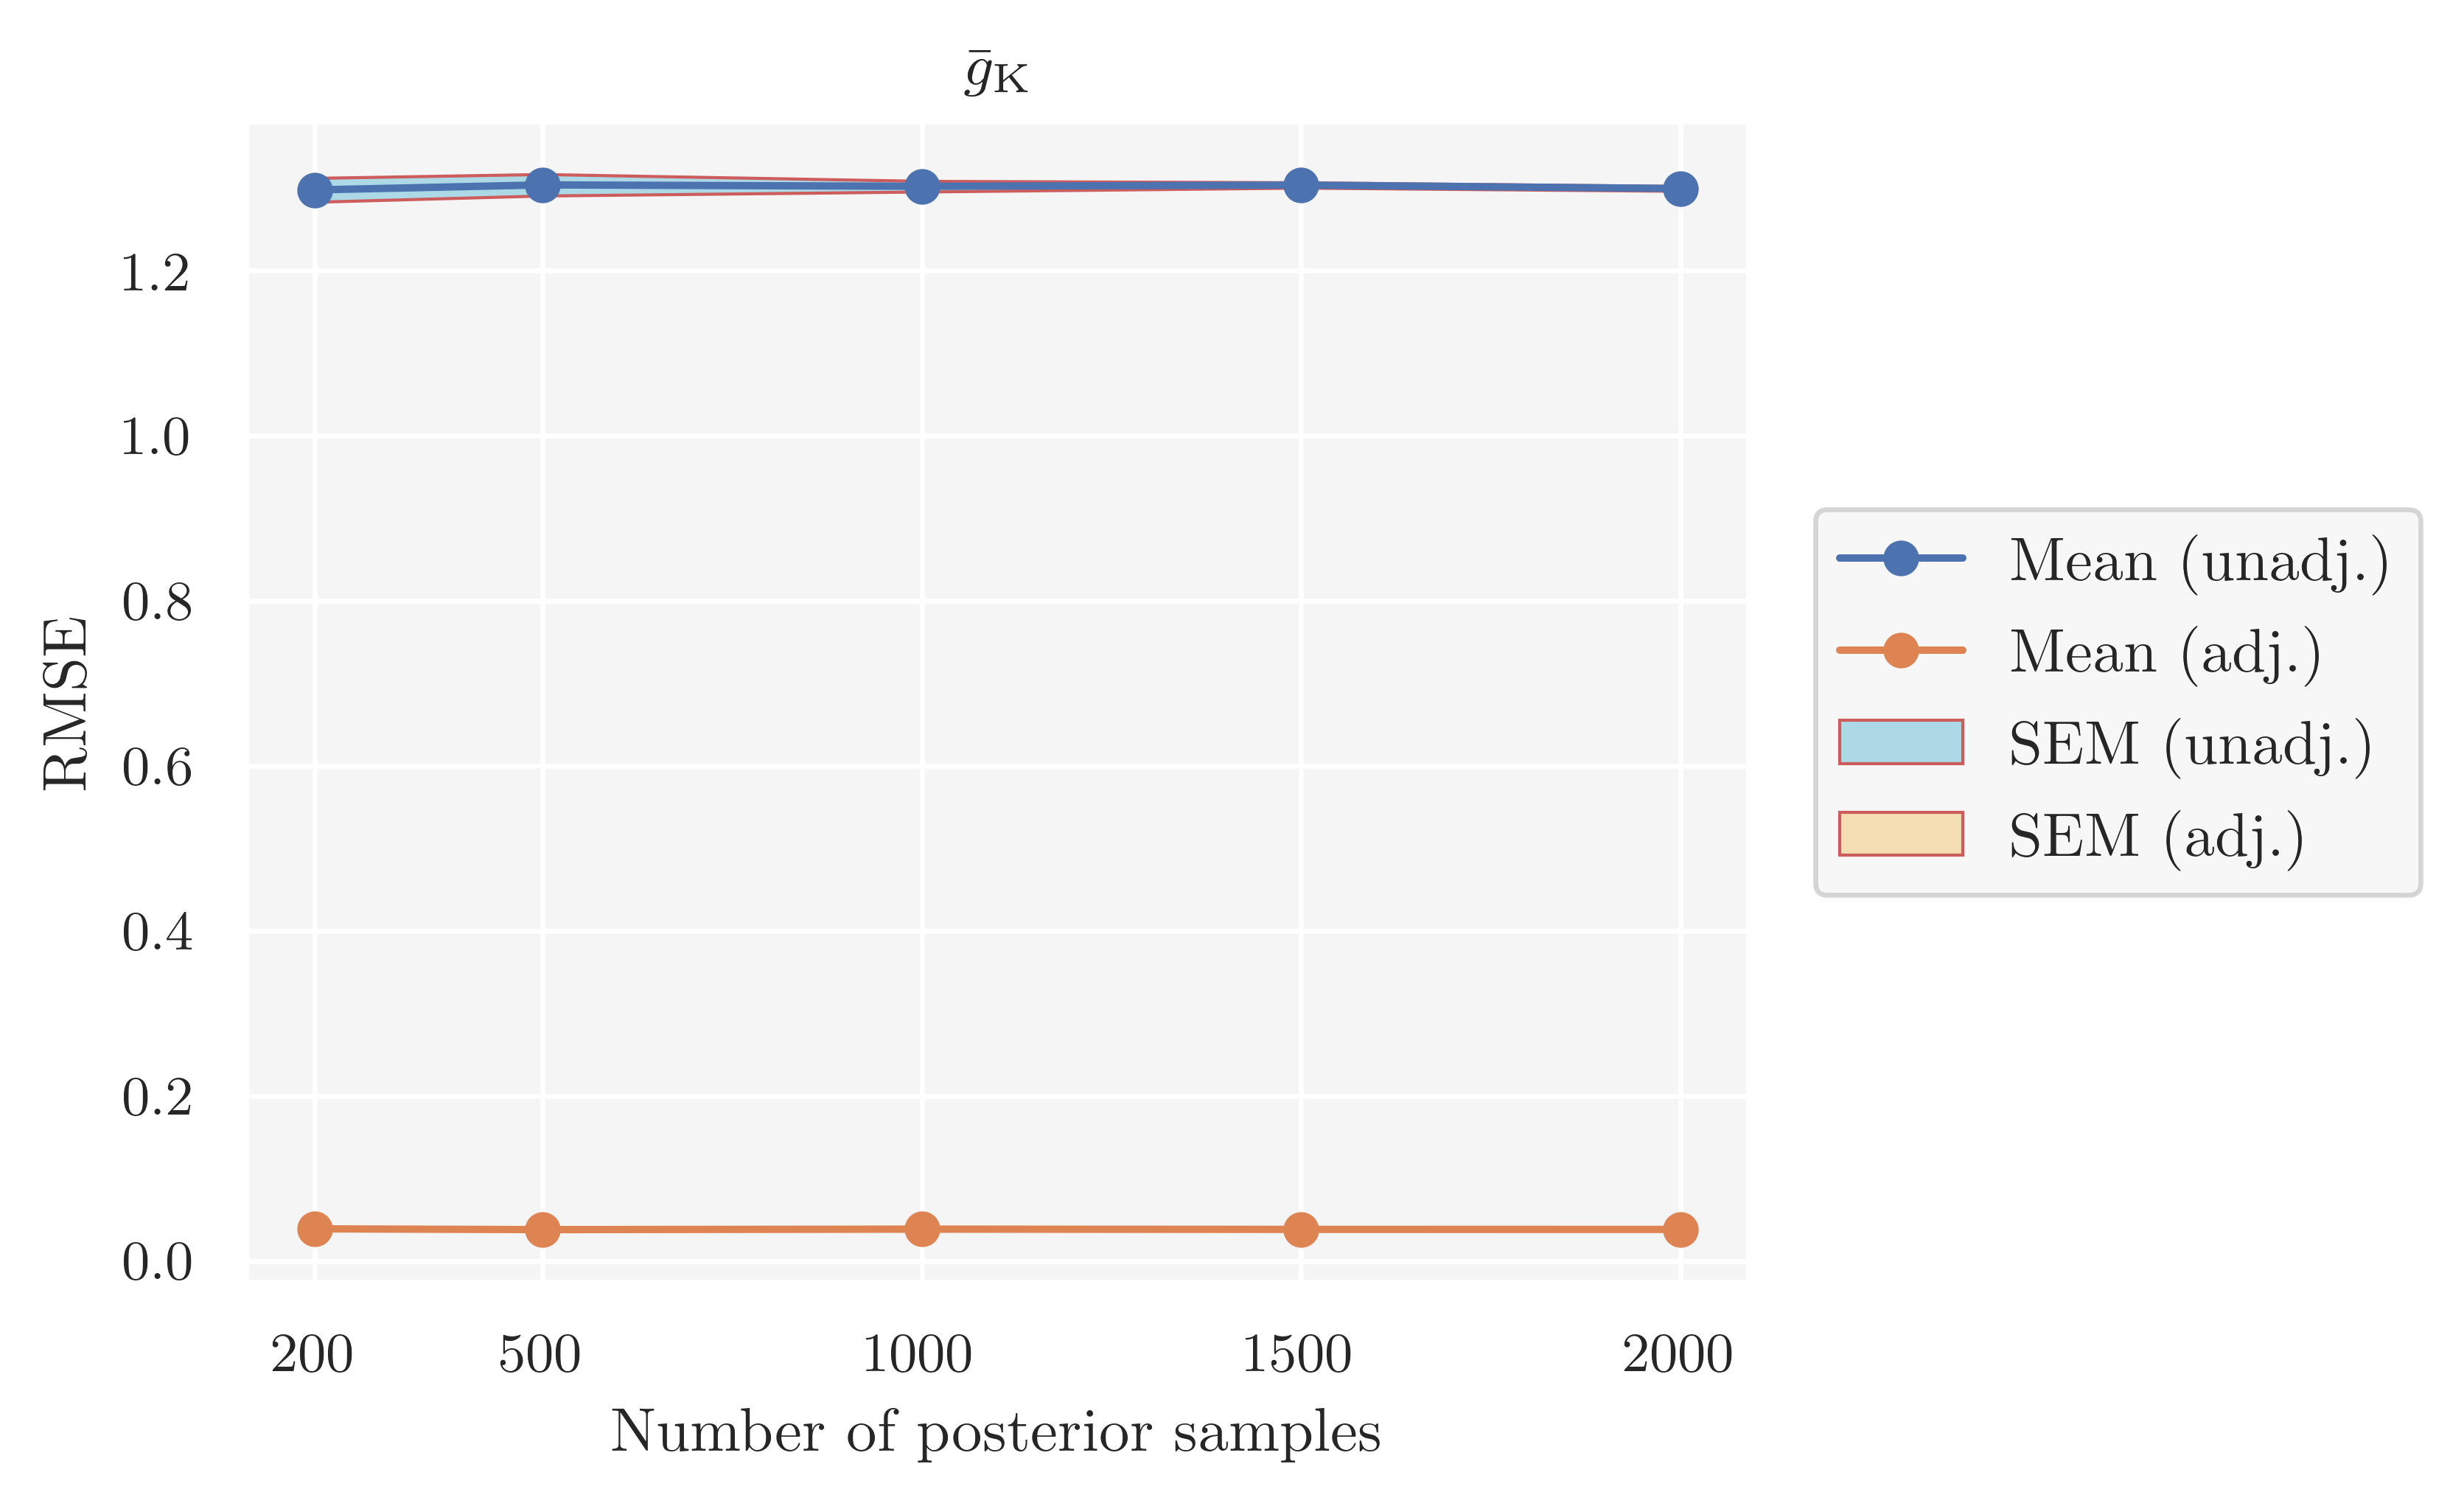

In [66]:
# gbarK

fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)
# original posterior samples
ax.plot(nsamples_lst, 
        gbarK_org_rmse_mean, 
        '-o',
        label='Mean (unadj.)', 
        color='C0'
        )
ax.fill_between(nsamples_lst, 
                gbarK_org_rmse_mean - gbarK_org_rmse_sem, 
                gbarK_org_rmse_mean + gbarK_org_rmse_sem,
                alpha=1.0,
                facecolor='lightblue',
                edgecolor='indianred',
                lw=0.5,
                label='SEM (unadj.)'
                )
# regression adjusted posterior samples
ax.plot(nsamples_lst, 
        gbarK_reg_rmse_mean, 
        '-o', 
        label='Mean (adj.)', 
        color='C1'
        )
ax.fill_between(nsamples_lst, 
                gbarK_reg_rmse_mean - gbarK_reg_rmse_sem, 
                gbarK_reg_rmse_mean + gbarK_reg_rmse_sem,
                alpha=1.0,
                facecolor='wheat',
                edgecolor='indianred',
                lw=0.5,
                label='SEM (adj.)'
                )

ax.set(xticks=nsamples_lst,
       xlabel='Number of posterior samples',
       ylabel="RMSE",
       title=r'$\bar{g}_\mathrm{K}$'
       )

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles,
          labels,
          loc='center left',
          bbox_to_anchor=(1.04, 0.5),
          fancybox=True,
          borderaxespad=0.1,
          ncol=1
         )
 
fig.savefig(fig_path('rmse_nsamples_gbarK_normal.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

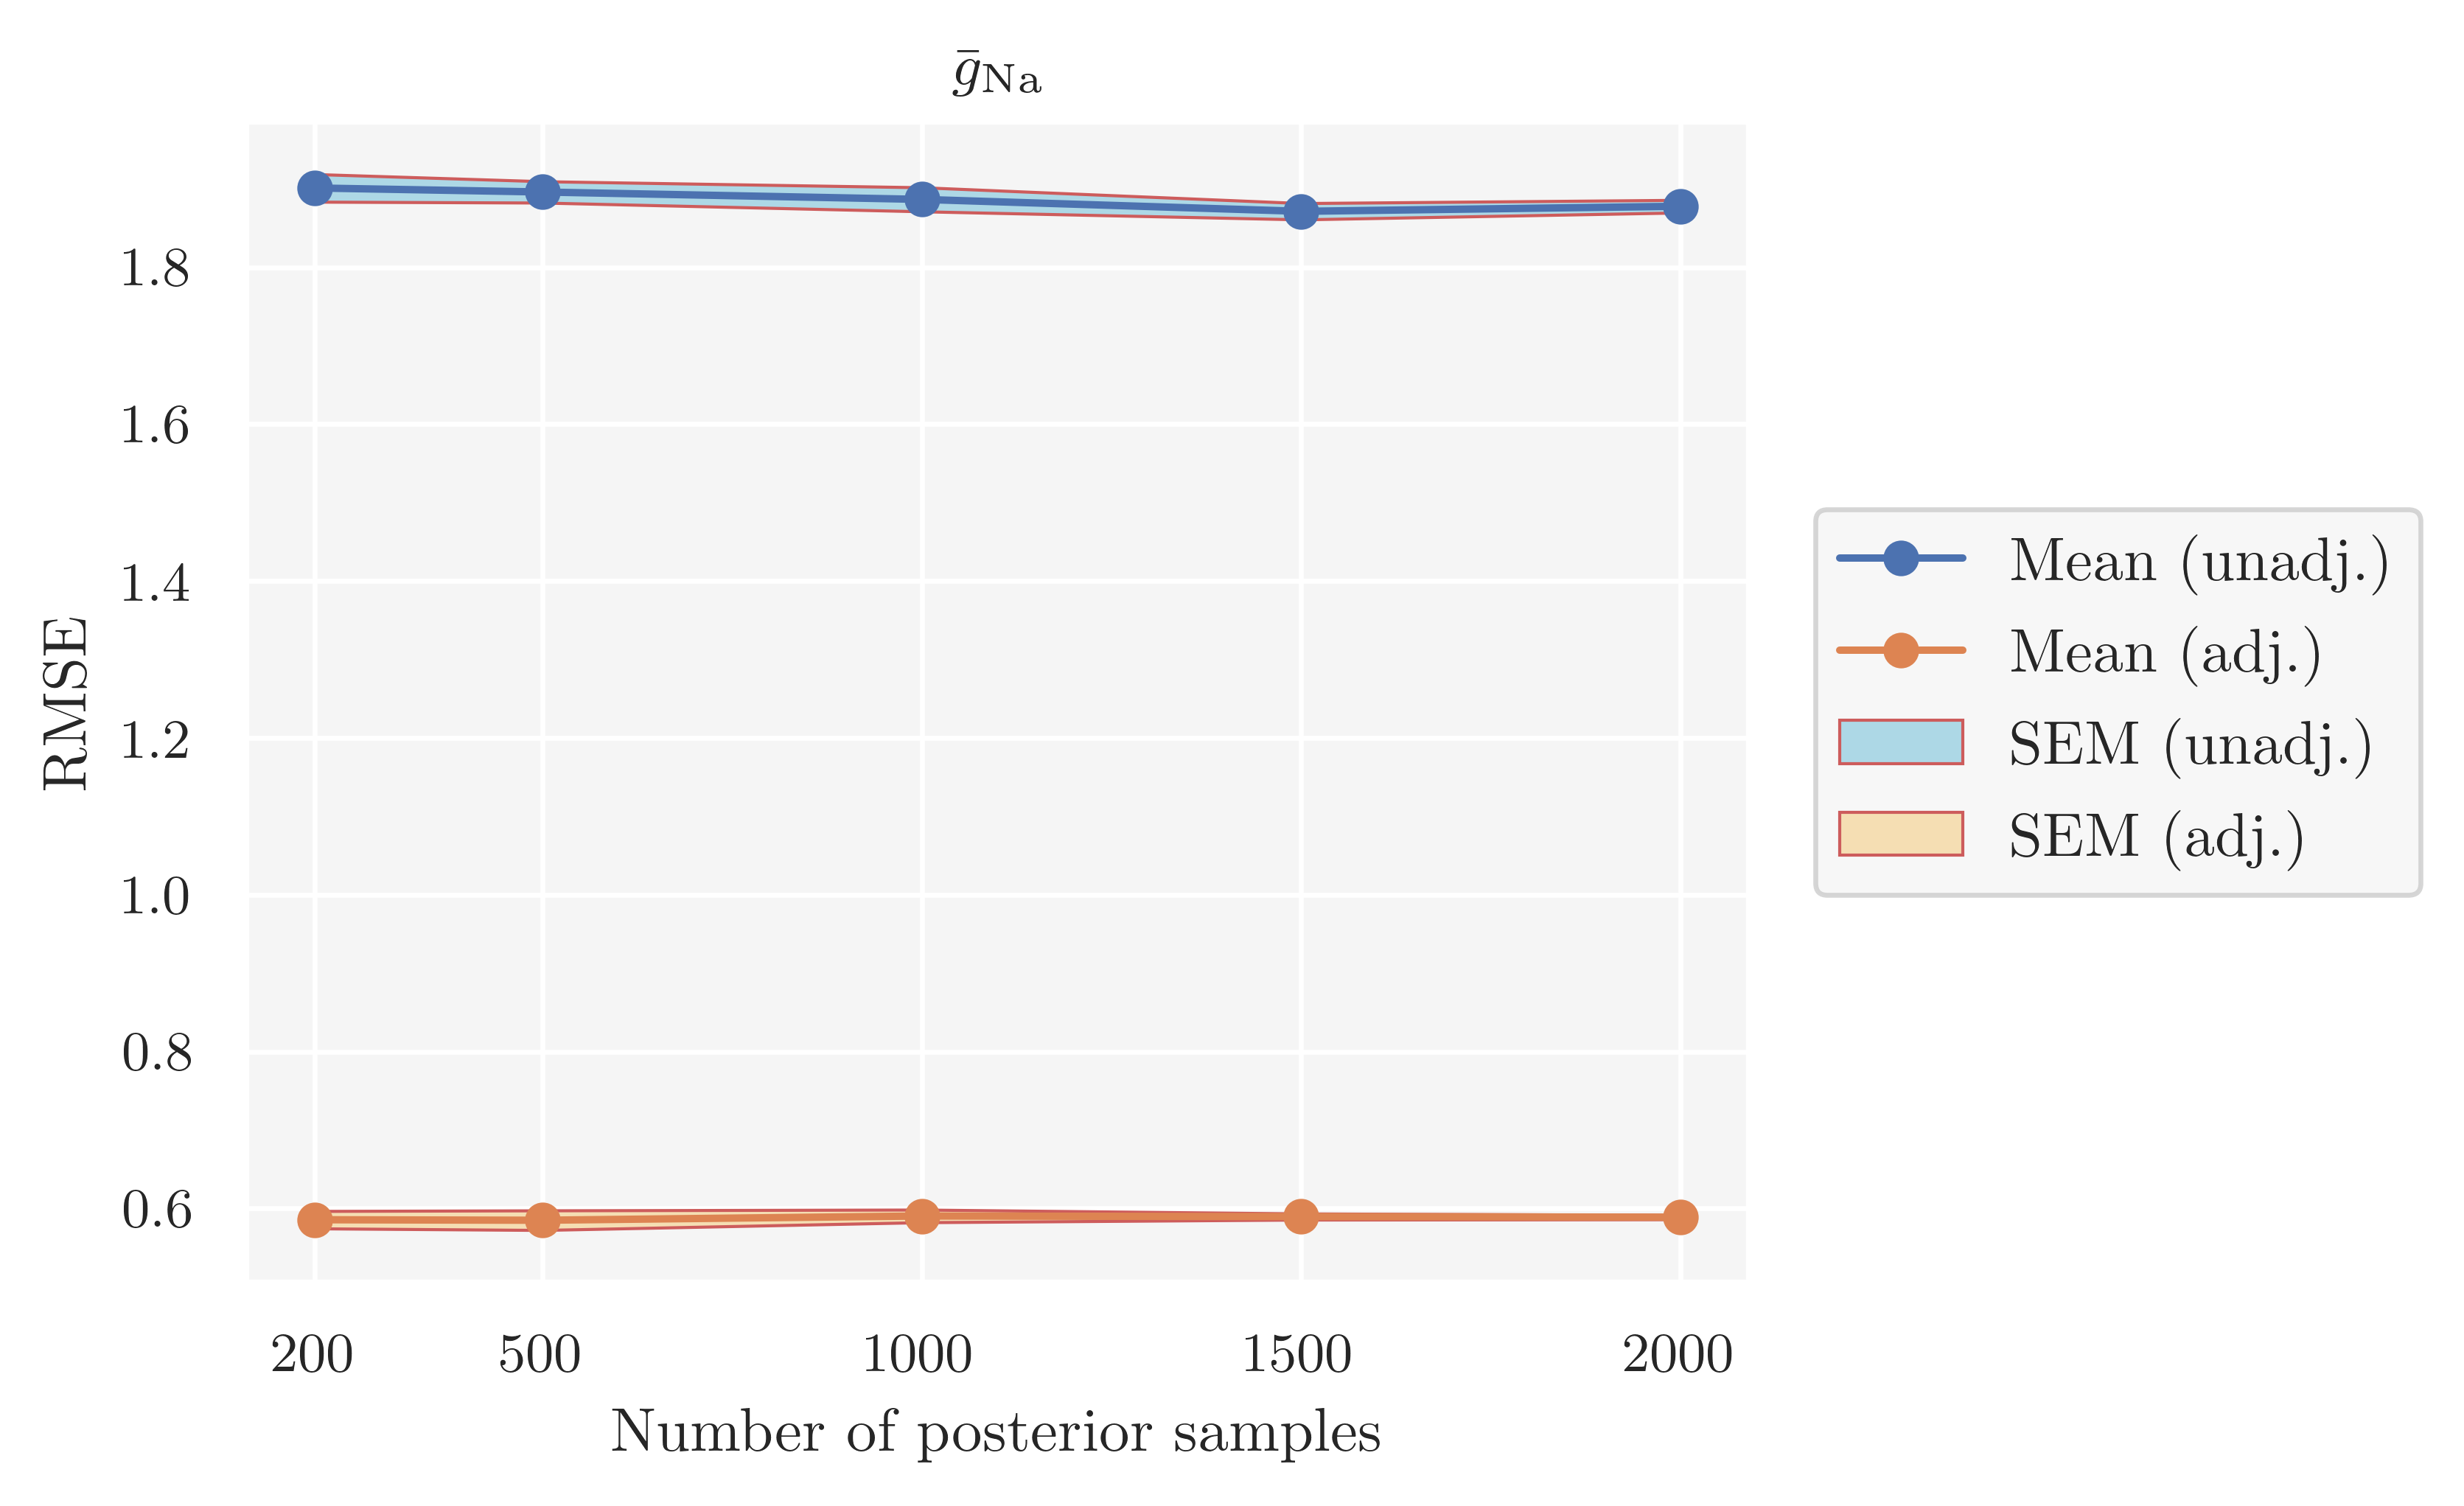

In [76]:
# gbarNa

fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)
# original posterior samples
ax.plot(nsamples_lst, 
        gbarNa_org_rmse_mean, 
        '-o',
        label='Mean (unadj.)', 
        color='C0'
        )
ax.fill_between(nsamples_lst, 
                gbarNa_org_rmse_mean - gbarNa_org_rmse_sem, 
                gbarNa_org_rmse_mean + gbarNa_org_rmse_sem,
                alpha=1.0,
                facecolor='lightblue',
                edgecolor='indianred',
                lw=0.5,
                label='SEM (unadj.)'
                )
# regression adjusted posterior samples
ax.plot(nsamples_lst, 
        gbarNa_reg_rmse_mean, 
        '-o', 
        label='Mean (adj.)', 
        color='C1'
        )
ax.fill_between(nsamples_lst, 
                gbarNa_reg_rmse_mean - gbarNa_reg_rmse_sem, 
                gbarNa_reg_rmse_mean + gbarNa_reg_rmse_sem,
                alpha=1.0,
                facecolor='wheat',
                edgecolor='indianred',
                lw=0.5,
                label='SEM (adj.)'
                )

ax.set(xticks=nsamples_lst,
       xlabel=r'Number of posterior samples',
       ylabel="RMSE",
       title=r'$\bar{g}_\mathrm{Na}$'
       )
ax.legend()

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles,
          labels,
          loc='center left',
          bbox_to_anchor=(1.04, 0.5),
          fancybox=True,
          borderaxespad=0.1,
          ncol=1
         )
 
fig.savefig(fig_path('rmse_nsamples_gbarNa_normal.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

#### Uniform prior

In [58]:
gbarK0 = 36.    # ground truth
gbarNa0 = 120.  # ground truth

path = 'data/'

# iterators
nsamples_lst = [200, 500, 1000, 1500, 2000]
trials = 10
N = len(quantile_lst)

# original posterior samples
gbarK_org_rmse_mean = np.zeros(N)
gbarK_org_rmse_sem = np.zeros(N)
gbarNa_org_rmse_mean = np.zeros(N)
gbarNa_org_rmse_sem = np.zeros(N)

# regression adjusted posterior samples
gbarK_reg_rmse_mean = np.zeros(N)
gbarK_reg_rmse_sem = np.zeros(N)
gbarNa_reg_rmse_mean = np.zeros(N)
gbarNa_reg_rmse_sem = np.zeros(N)

for i, nsamples in enumerate(nsamples_lst):
    
    gbarK_true = np.ones(nsamples) * gbarK0
    gbarNa_true = np.ones(nsamples) * gbarNa0
    
    # original posterior samples
    trial_gbarK_rmse_org = np.zeros(trials)
    trial_gbarNa_rmse_org = np.zeros(trials)
    
    # regression adjusted posterior samples
    trial_gbarK_rmse_reg = np.zeros(trials)
    trial_gbarNa_rmse_reg = np.zeros(trials)
    
    for trial in range(trials):
        # original posterior samples
        filename = f'hh_rej_uniform_org_nsamples_{nsamples}_run_{trial}.jnl'
        journal = pylfi.Journal.load(path + filename)
        df = journal.df
        trial_gbarK_rmse_org[trial] = rmse(gbarK_true, df["gbarK"].to_numpy())
        trial_gbarNa_rmse_org[trial] = rmse(gbarNa_true, df["gbarNa"].to_numpy()) 
        
        # regression adjusted posterior samples
        filename = f'hh_rej_uniform_reg_nsamples_{nsamples}_run_{trial}.jnl'
        journal = pylfi.Journal.load(path + filename)
        df = journal.df
        trial_gbarK_rmse_reg[trial] = rmse(gbarK_true, df["gbarK"].to_numpy())
        trial_gbarNa_rmse_reg[trial] = rmse(gbarNa_true, df["gbarNa"].to_numpy()) 
        
    # Mean and SEM of RMSE samples
    # Original posterior
    gbarK_org_rmse_mean[i] = np.mean(trial_gbarK_rmse_org)
    gbarK_org_rmse_sem[i] = sem(trial_gbarK_rmse_org) 
    gbarNa_org_rmse_mean[i] = np.mean(trial_gbarNa_rmse_org)
    gbarNa_org_rmse_sem[i] = sem(trial_gbarNa_rmse_org) 
    
    # Adjusted posterior
    gbarK_reg_rmse_mean[i] = np.mean(trial_gbarK_rmse_reg)
    gbarK_reg_rmse_sem[i] = sem(trial_gbarK_rmse_reg) 
    gbarNa_reg_rmse_mean[i] = np.mean(trial_gbarNa_rmse_reg)
    gbarNa_reg_rmse_sem[i] = sem(trial_gbarNa_rmse_reg)

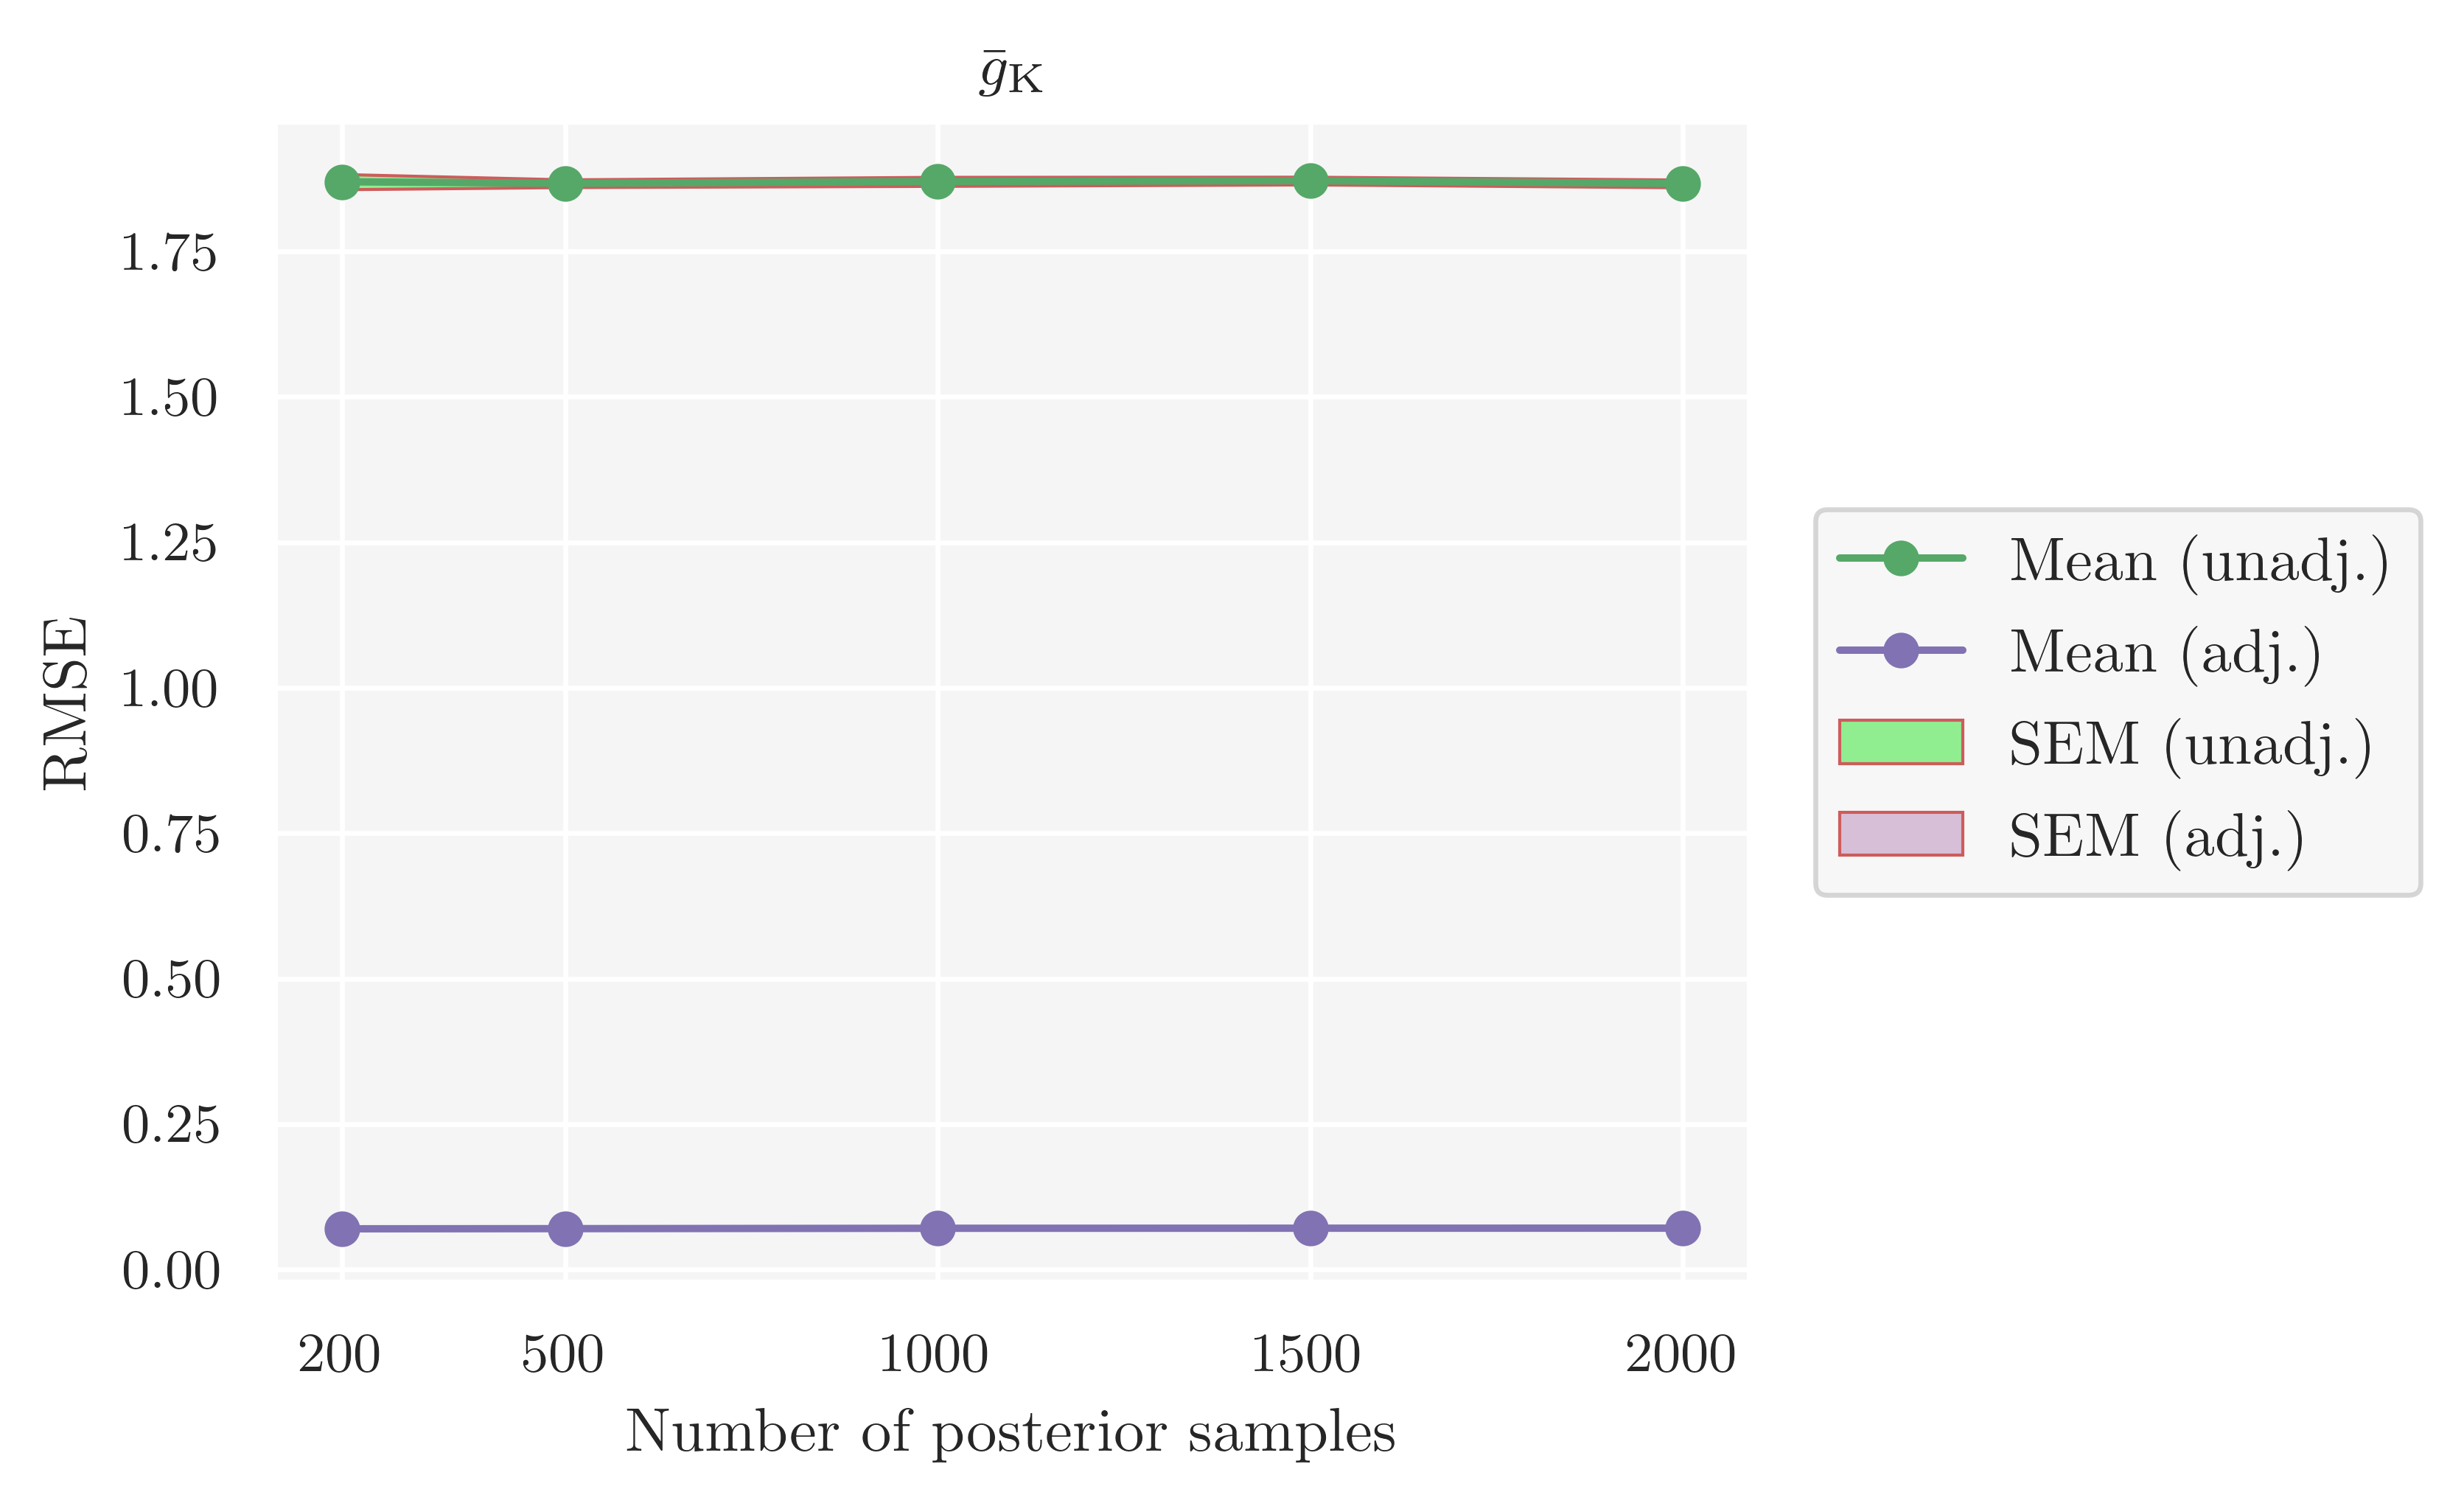

In [64]:
# gbarK

fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)
# original posterior samples
ax.plot(nsamples_lst, 
        gbarK_org_rmse_mean, 
        '-o',
        label='Mean (unadj.)', 
        color='C2'
        )
ax.fill_between(nsamples_lst, 
                gbarK_org_rmse_mean - gbarK_org_rmse_sem, 
                gbarK_org_rmse_mean + gbarK_org_rmse_sem,
                alpha=1.0,
                facecolor='lightgreen',
                edgecolor='indianred',
                lw=0.5,
                label='SEM (unadj.)'
                )
# regression adjusted posterior samples
ax.plot(nsamples_lst, 
        gbarK_reg_rmse_mean, 
        '-o', 
        label='Mean (adj.)', 
        color='C4'
        )
ax.fill_between(nsamples_lst, 
                gbarK_reg_rmse_mean - gbarK_reg_rmse_sem, 
                gbarK_reg_rmse_mean + gbarK_reg_rmse_sem,
                alpha=1.0,
                facecolor='thistle',
                edgecolor='indianred',
                lw=0.5,
                label='SEM (adj.)'
                )

ax.set(xticks=nsamples_lst,
       xlabel='Number of posterior samples',
       ylabel="RMSE",
       title=r'$\bar{g}_\mathrm{K}$'
       )

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles,
          labels,
          loc='center left',
          bbox_to_anchor=(1.04, 0.5),
          fancybox=True,
          borderaxespad=0.1,
          ncol=1
         )
 
fig.savefig(fig_path('rmse_nsamples_gbarK_normal.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

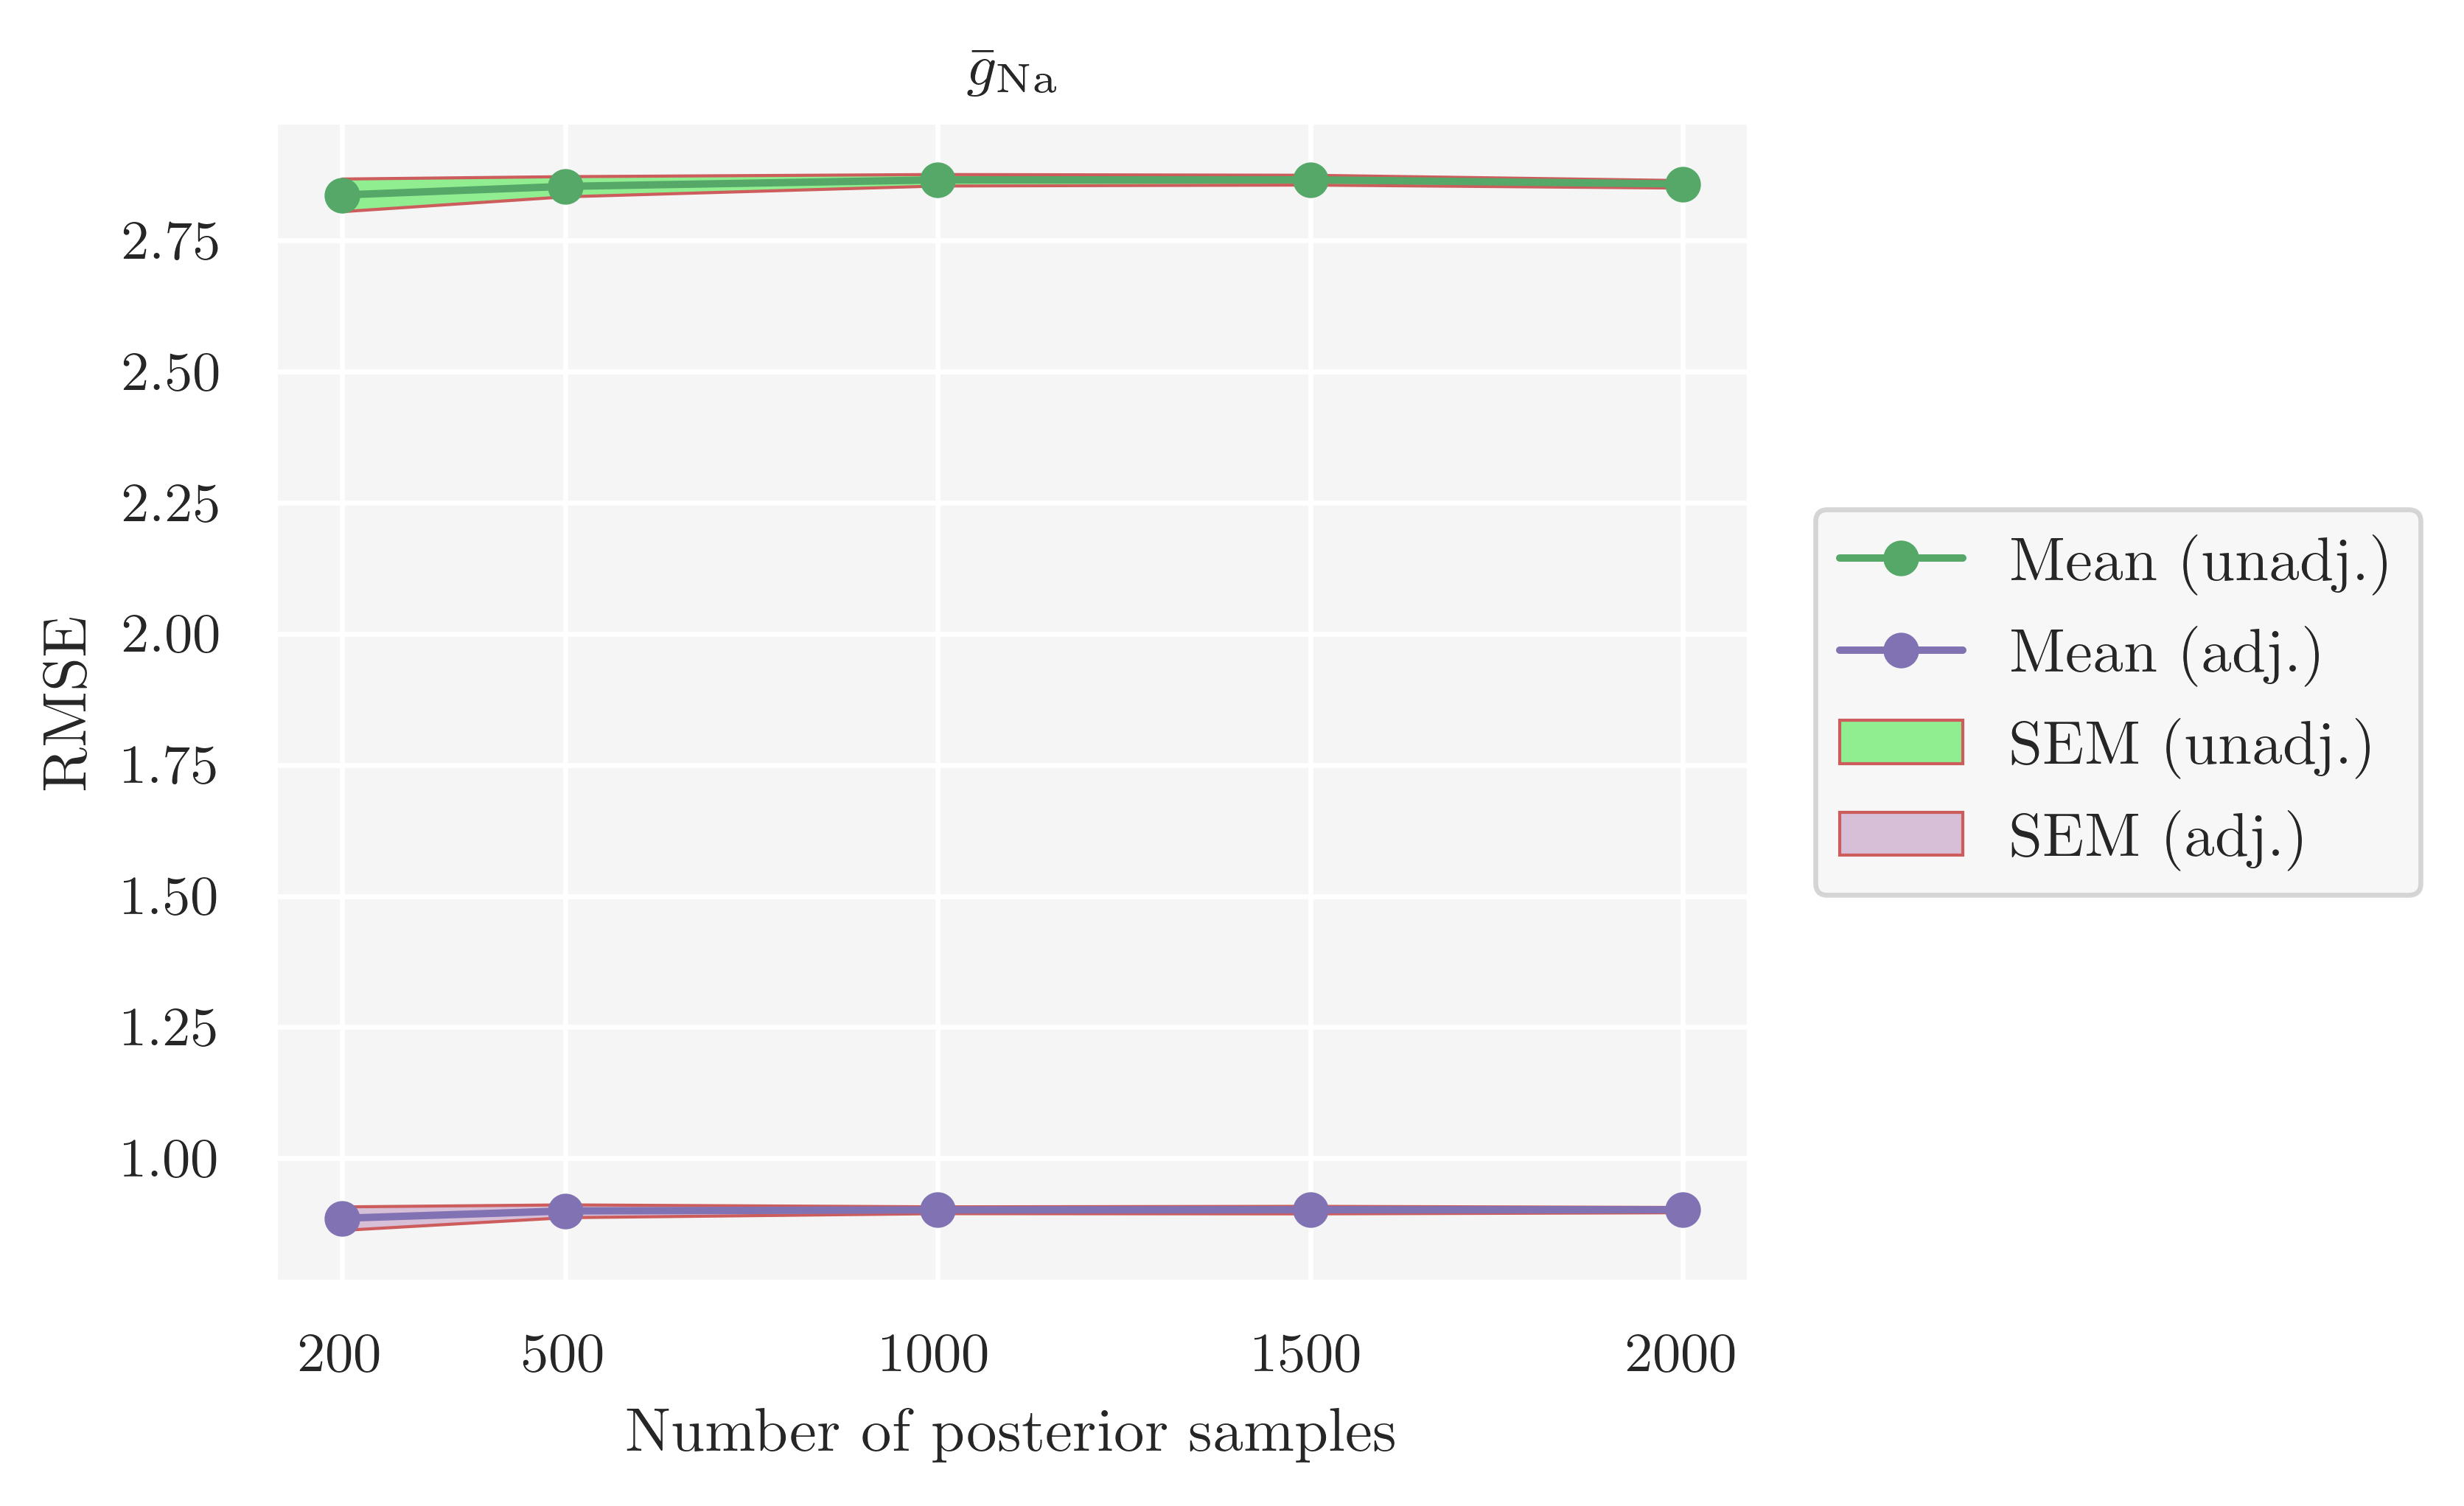

In [63]:
# gbarNa

fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)
# original posterior samples
ax.plot(nsamples_lst, 
        gbarNa_org_rmse_mean, 
        '-o',
        label='Mean (unadj.)', 
        color='C2'
        )
ax.fill_between(nsamples_lst, 
                gbarNa_org_rmse_mean - gbarNa_org_rmse_sem, 
                gbarNa_org_rmse_mean + gbarNa_org_rmse_sem,
                alpha=1.0,
                facecolor='lightgreen',
                edgecolor='indianred',
                lw=0.5,
                label='SEM (unadj.)'
                )
# regression adjusted posterior samples
ax.plot(nsamples_lst, 
        gbarNa_reg_rmse_mean, 
        '-o', 
        label='Mean (adj.)', 
        color='C4'
        )
ax.fill_between(nsamples_lst, 
                gbarNa_reg_rmse_mean - gbarNa_reg_rmse_sem, 
                gbarNa_reg_rmse_mean + gbarNa_reg_rmse_sem,
                alpha=1.0,
                facecolor='thistle',
                edgecolor='indianred',
                lw=0.5,
                label='SEM (adj.)'
                )

ax.set(xticks=nsamples_lst,
       xlabel=r'Number of posterior samples',
       ylabel="RMSE",
       title=r'$\bar{g}_\mathrm{Na}$'
       )
ax.legend()

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles,
          labels,
          loc='center left',
          bbox_to_anchor=(1.04, 0.5),
          fancybox=True,
          borderaxespad=0.1,
          ncol=1
         )
 
fig.savefig(fig_path('rmse_nsamples_gbarNa_normal.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

### Roadmap

* RMSE vs number of summary statistics 
    * include RMSE of runs with importance weights
    * only show reg adjusted posteriors
* MCMC hyperparams
    * RMSE number of tuning iterations
    * number of posterior samples vs chain convergence
* Best posteriors
    * plot best posteriors from REJ-ABC and MCMC-ABC (reg. adjusted with credible intervals and point estimates)
    * Need trace plot of chains for (at least) MCMC
    * Covariance matrix 
    * Posterior predictive distribution
* Brunel
    * REJ- and MCMC ABC posteriors for different states (reg. adjusted with credible intervals and point estimates)
    * PPC?

### Test ground